#0) Imports and Installs

In [269]:
!pip install yfinance

In [270]:
# IMPORTS
import numpy as np
import pandas as pd
import requests


#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt

# 1) [Code Snippet 1] IPOs data from Web

* learn dataframes "stacking" (UNION ALL)
* learn about type casting
* generate new columns (simple and with function)


In [271]:
import pandas as pd
import requests
from io import StringIO

def get_ipos_by_year(year: int) -> pd.DataFrame:
    """
    Fetch IPO data for the given year from stockanalysis.com.
    """
    url = f"https://stockanalysis.com/ipos/{year}/"
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Wrap HTML text in StringIO to avoid deprecation warning
        # "Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object."
        html_io = StringIO(response.text)
        tables = pd.read_html(html_io)

        if not tables:
            raise ValueError(f"No tables found for year {year}.")

        return tables[0]

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Data error: {ve}")
    except Exception as ex:
        print(f"Unexpected error: {ex}")

    return pd.DataFrame()

In [272]:
ipos_2023 = get_ipos_by_year(2023)
ipos_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      153 non-null    object
 1   Symbol        153 non-null    object
 2   Company Name  153 non-null    object
 3   IPO Price     153 non-null    object
 4   Current       153 non-null    object
 5   Return        153 non-null    object
dtypes: object(6)
memory usage: 7.3+ KB


In [273]:
ipos_2024 = get_ipos_by_year(2024)
ipos_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      225 non-null    object
 1   Symbol        225 non-null    object
 2   Company Name  225 non-null    object
 3   IPO Price     225 non-null    object
 4   Current       225 non-null    object
 5   Return        225 non-null    object
dtypes: object(6)
memory usage: 10.7+ KB


In [274]:
ipos_2025 = get_ipos_by_year(2025)
ipos_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      143 non-null    object
 1   Symbol        143 non-null    object
 2   Company Name  143 non-null    object
 3   IPO Price     143 non-null    object
 4   Current       143 non-null    object
 5   Return        143 non-null    object
dtypes: object(6)
memory usage: 6.8+ KB


In [275]:
# "stacking dataframes"
# pd.concat() is used to concatenate the DataFrames vertically.
# The ignore_index=True parameter ensures that the resulting DataFrame has a new index,
# ignoring the original indices of the input DataFrames.
# The stacked_df now contains the concatenated DataFrame.
stacked_ipos_df = pd.concat([ipos_2025, ipos_2024, ipos_2023], ignore_index=True)

In [276]:
stacked_ipos_df.head(1)

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,"Jun 6, 2025",OMDA,"Omada Health, Inc.",$19.00,$23.00,21.05%


In [277]:
# Need to convert everything to a proper type (date, str, int, float, etc.)
stacked_ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      521 non-null    object
 1   Symbol        521 non-null    object
 2   Company Name  521 non-null    object
 3   IPO Price     521 non-null    object
 4   Current       521 non-null    object
 5   Return        521 non-null    object
dtypes: object(6)
memory usage: 24.6+ KB


In [278]:
# convert to datetime
stacked_ipos_df['IPO Date'] = pd.to_datetime(stacked_ipos_df['IPO Date'], format='mixed')

In [279]:
# Problem --> not always the columns are filled
missing_prices_df = stacked_ipos_df[stacked_ipos_df['IPO Price'].astype(str).str.find('-') >= 0]
missing_prices_df

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
62,2025-04-02,SORA,Top Win International Limited,-,$6.30,-
204,2024-10-11,STFS,Star Fashion Culture Holdings Limited,-,$1.20,-
263,2024-07-23,ZDAI,Primega Group Holdings Limited,-,$0.83,-
291,2024-05-31,NAKA,"Kindly MD, Inc.",-,$15.88,-
317,2024-04-17,SUPX,SuperX AI Technology Limited,-,$10.14,-


In [280]:
# it has some missing values --> use defensive errors='coerce' (if don't have time to crack into the data errors)
#     : pd.to_numeric() function call, which will convert problematic values to NaN.
#     otherwise you'll get a ValueError: Unable to parse string "-" at position 9
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'].str.replace('$', ''), errors='coerce')
# not sure why, but need to call it again to transform 'object' to 'float64'
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'])

In [281]:
# Convert "Current" column
stacked_ipos_df['Current'] = pd.to_numeric(stacked_ipos_df['Current'].str.replace('$', ''), errors='coerce')

# Convert 'Return' to numeric format (percentage)
stacked_ipos_df['Return'] = pd.to_numeric(stacked_ipos_df['Return'].str.replace('%', ''), errors='coerce') / 100

In [282]:
# Correctly applied transformations with 'defensive' techniques, but now not all are non-null
stacked_ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   IPO Date      521 non-null    datetime64[ns]
 1   Symbol        521 non-null    object        
 2   Company Name  521 non-null    object        
 3   IPO Price     516 non-null    float64       
 4   Current       521 non-null    float64       
 5   Return        513 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 24.6+ KB


In [283]:
# simple way of checking NULLs
# (you need to understand how vector operations work .isnull() and calls chaining .isnull().sum())
stacked_ipos_df.isnull().sum()

,0
IPO Date,0
Symbol,0
Company Name,0
IPO Price,5
Current,0
Return,8


In [284]:
# Do you want to leave the record or not?
stacked_ipos_df[stacked_ipos_df.Return.isnull()]

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
59,2025-04-04,BLIV,BeLive Holdings,4.0,4.00,NaN
62,2025-04-02,SORA,Top Win International Limited,NaN,6.30,NaN
127,2025-01-22,DGNX,Diginex Limited,4.1,63.00,NaN
204,2024-10-11,STFS,Star Fashion Culture Holdings Limited,NaN,1.20,NaN
216,2024-09-30,ZJK,"ZJK Industrial Co., Ltd.",5.0,5.00,NaN
263,2024-07-23,ZDAI,Primega Group Holdings Limited,NaN,0.83,NaN
291,2024-05-31,NAKA,"Kindly MD, Inc.",NaN,15.88,NaN
317,2024-04-17,SUPX,SuperX AI Technology Limited,NaN,10.14,NaN


In [285]:
# now you can operate with columns as a numeric type
stacked_ipos_df['IPO Price'].mean()

np.float64(10.597383720930232)

In [286]:
# generate a new field -- SIMPLE calculation (no function needed)
stacked_ipos_df['Price Increase'] = stacked_ipos_df['Current'] - stacked_ipos_df['IPO Price']
stacked_ipos_df['Price Increase'].mean()

np.float64(0.8945155038759689)

In [287]:
stacked_ipos_df.head(1)

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,Price Increase
0,2025-06-06,OMDA,"Omada Health, Inc.",19.0,23.0,0.2105,4.0


In [288]:
# Descriptive Analytics of a dataset
stacked_ipos_df.describe()

,IPO Date,IPO Price,Current,Return,Price Increase
count,521,516.000000,521.000000,513.000000,516.000000
mean,2024-06-02 05:12:19.347408896,10.597384,11.447543,-0.099708,0.894516
min,2023-01-13 00:00:00,2.500000,0.000000,-0.999500,-38.620000
25%,2023-10-31 00:00:00,4.000000,1.670000,-0.709000,-3.482500
50%,2024-07-25 00:00:00,10.000000,7.420000,-0.083900,-0.675000
75%,2025-01-22 00:00:00,11.000000,11.080000,0.086700,0.850000
max,2025-06-06 00:00:00,92.000000,140.160000,6.797500,100.160000
std,NaN,9.811783,17.946664,0.862669,12.815406


In [289]:
# some visualisation: bar chart using Plotly Express
import plotly.express as px

# Truncate to the first day in the month - for Bar names
stacked_ipos_df['Date_monthly'] = stacked_ipos_df['IPO Date'].dt.to_period('M').dt.to_timestamp()

# Count the number of deals for each month and year
monthly_deals = stacked_ipos_df['Date_monthly'].value_counts().reset_index().sort_values(by='Date_monthly')
monthly_deals.columns = ['Date_monthly', 'Number of Deals']

# Plotting the bar chart using Plotly Express
fig = px.bar(monthly_deals,
             x='Date_monthly',
             y='Number of Deals',
             labels={'Month_Year': 'Month and Year', 'Number of Deals': 'Number of Deals'},
             title='Number of IPO Deals per Month and Year',
             text='Number of Deals'
             )
fig.update_traces(textposition='outside', # Position the text outside the bars
                  textfont=dict(color='black',size=14), # Adjust the font size of the text
                  )
fig.update_layout(title_x=0.5) # Center the title

fig.show()

In [290]:
rddt_filter = stacked_ipos_df.Symbol=='RDDT'
stacked_ipos_df[rddt_filter]

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,Price Increase,Date_monthly
332,2024-03-21,RDDT,"Reddit, Inc.",34.0,121.29,2.5674,87.29,2024-03-01


In [291]:
# To be used for home assignment: 'You can notice a bump in the price after the IPO? And after that the price goes down
# You're asked to design a simple strategy to buy and hold for X days (at 'Adj.Close' price, no fees)
# Find an optimal X between 1 and 30, that delivers you a MAX mean return on ALL 2023 IPOs?
# Write down the answer X (a number between 1 and 30)

# What is the distribution of other returns 25-50-75% quantiles? Compare mean and median returns for 2023 (median may be more robust),
  # are you losing money in 25% cases (if 25% quantile returns is < 0)
  # Try the same X for all deals in 2024.  How the mean return in 2024 (out of sample data) is different from 2023 data?

# REDDIT - recent IPO
# https://finance.yahoo.com/quote/RDDT/
ticker_obj = yf.Ticker("RDDT")
reddit = ticker_obj.history(period = "max", interval = "1d")

reddit.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-02 00:00:00-04:00,109.160004,113.660004,109.160004,112.110001,4539400,0.0,0.0
2025-06-03 00:00:00-04:00,112.459999,115.387001,109.919998,110.860001,5462500,0.0,0.0
2025-06-04 00:00:00-04:00,110.870003,119.690002,110.870003,118.209999,8683400,0.0,0.0
2025-06-05 00:00:00-04:00,118.760002,119.230003,111.849998,112.239998,6231800,0.0,0.0
2025-06-06 00:00:00-04:00,113.629997,121.290001,112.769997,121.290001,6748700,0.0,0.0


In [292]:
ipos_2023

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,"Dec 27, 2023",IROH,Iron Horse Acquisitions Corp.,$10.00,$10.49,4.90%
1,"Dec 19, 2023",LGCB,Linkage Global Inc,$4.00,$2.41,-39.75%
2,"Dec 15, 2023",BAYA,Bayview Acquisition Corp,$10.00,$11.03,10.30%
3,"Dec 15, 2023",ZKH,ZKH Group Limited,$15.50,$3.07,-80.19%
4,"Dec 14, 2023",INHD,Inno Holdings Inc.,$4.00,$1.32,-67.00%
...,...,...,...,...,...,...
148,"Jan 25, 2023",QSG,QuantaSing Group Limited,$12.50,$6.68,-46.56%
149,"Jan 20, 2023",CVKD,"Cadrenal Therapeutics, Inc.",$5.00,$15.10,202.00%
150,"Jan 13, 2023",ISRL,Israel Acquisitions Corp,$10.00,$12.43,24.30%
151,"Jan 13, 2023",MGOL,MGO Global Inc.,$5.00,$0.37,-92.60%


In [293]:
ipos_2023 = get_ipos_by_year(2023)
ipos_2023['IPO Date'] = pd.to_datetime(ipos_2023['IPO Date'], errors='coerce')
ipos_2023 = ipos_2023.dropna(subset=['IPO Date', 'Symbol'])  # Drop rows with missing values
ipos_2023 = ipos_2023[['Symbol', 'IPO Date']].drop_duplicates()

In [294]:
ipos_2023

,Symbol,IPO Date
0,IROH,2023-12-27
1,LGCB,2023-12-19
2,BAYA,2023-12-15
3,ZKH,2023-12-15
4,INHD,2023-12-14
...,...,...
148,QSG,2023-01-25
149,CVKD,2023-01-20
150,ISRL,2023-01-13
151,MGOL,2023-01-13


In [295]:
def collect_ipo_returns(ipos_df):
    from datetime import timedelta
    import yfinance as yf
    import numpy as np

    results = {}
    failed_symbols = []

    for idx, row in ipos_df.iterrows():
        symbol = row['Symbol']
        ipo_date = row['IPO Date']

        try:
            df = yf.download(symbol, start=ipo_date, end=ipo_date + timedelta(days=60), progress=False)
            df = df[df['Close'].notna()].head(31)

            if len(df) < 2:
                failed_symbols.append(symbol)
                continue

            for x in range(1, min(31, len(df))):
                ret = (df['Close'].iloc[x] / df['Close'].iloc[0]) - 1
                results.setdefault(x, []).append(ret)

        except Exception as e:
            print(f"{symbol} failed: {e}")
            failed_symbols.append(symbol)

    return results, failed_symbols


In [296]:
results, failed = collect_ipo_returns(ipos_2023)

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['RYZB']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NNAG']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SPGC']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LQR']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HRYU']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PXDT']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['WRNT']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['IPXX']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SGE']: YFTzMi

In [297]:
def analyze_ipo_returns(results_dict):
    """
    Analyzes daily returns over holding periods from 1 to 30 days.

    Parameters:
        results_dict (dict): Dictionary of returns where keys are X (holding period) and values are lists of returns.

    Returns:
        summary_df (pd.DataFrame): DataFrame with mean, median, quantiles, and losing stats for each X.
        optimal_x (int): X value (1–30) with highest mean return.
    """
    summary = []

    for x in sorted(results_dict.keys()):
        daily_returns = results_dict[x]
        if len(daily_returns) == 0:
            continue

        summary.append({
            'X': x,
            'Mean Return': np.mean(daily_returns),
            'Median Return': np.median(daily_returns),
            '25% Quantile': np.percentile(daily_returns, 25),
            '50% Quantile': np.percentile(daily_returns, 50),
            '75% Quantile': np.percentile(daily_returns, 75),
            'Losing in 25% cases': np.percentile(daily_returns, 25) < 0,
            'Sample Size': len(daily_returns)
        })

    summary_df = pd.DataFrame(summary)
    if summary_df.empty:
        raise ValueError("No valid return data found to analyze.")

    optimal_row = summary_df.loc[summary_df['Mean Return'].idxmax()]
    optimal_x = int(optimal_row['X'])

    return summary_df, optimal_x


In [298]:
summary_df, optimal_x = analyze_ipo_returns(results)

In [299]:
print(f"✅ Best holding period X: {optimal_x} days")
display(summary_df[['X', 'Mean Return', 'Median Return', '25% Quantile', '75% Quantile', 'Losing in 25% cases']])

✅ Best holding period X: 1 days


,X,Mean Return,Median Return,25% Quantile,75% Quantile,Losing in 25% cases
0,1,-0.058160,-0.001251,-0.095703,0.012043,True
1,2,-0.072935,-0.002041,-0.137500,0.016779,True
2,3,-0.089956,-0.007619,-0.138996,0.010248,True
3,4,-0.091885,-0.024543,-0.154375,0.009632,True
4,5,-0.111223,-0.033457,-0.275133,0.006897,True
5,6,-0.120347,-0.059119,-0.270880,0.007857,True
6,7,-0.128331,-0.047324,-0.279385,0.006194,True
7,8,-0.134064,-0.070553,-0.294514,0.006151,True
8,9,-0.135768,-0.052654,-0.355843,0.011545,True
9,10,-0.125778,-0.073329,-0.331056,0.015262,True


In [300]:
ipos_2024['IPO Date'] = pd.to_datetime(ipos_2024['IPO Date'], errors='coerce')
ipos_2024 = ipos_2024.dropna(subset=['IPO Date', 'Symbol'])  # Drop rows with missing values
ipos_2024 = ipos_2024[['Symbol', 'IPO Date']].drop_duplicates()

In [301]:
results_2024, failed_2024 = collect_ipo_returns(ipos_2024)

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SPHA']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HSPT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-11-15 00:00:00 -> 2025-01-14 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1731646800, endDate = 1736830800")')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['IZTC']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['EURK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-07-02 00:00:00 -> 2024-08-31 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1719892800, endDate = 1725076800")')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SUPX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-04-17 00:00:00 -> 2024-06-16 00:00:00)')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['VHAI']: YFPricesMissingE

In [302]:
summary_df_2024, optimal_x_2024 = analyze_ipo_returns(results_2024)

In [303]:
print(f"✅ Best holding period X: {optimal_x_2024} days")
display(summary_df_2024[['X', 'Mean Return', 'Median Return', '25% Quantile', '75% Quantile', 'Losing in 25% cases']])

✅ Best holding period X: 7 days


,X,Mean Return,Median Return,25% Quantile,75% Quantile,Losing in 25% cases
0,1,0.010946,0.000000,-0.025014,0.034975,True
1,2,0.027049,0.000000,-0.037568,0.049783,True
2,3,0.030072,0.001002,-0.029698,0.070147,True
3,4,0.017480,0.001011,-0.054243,0.068412,True
4,5,0.021869,0.001009,-0.071588,0.069912,True
5,6,0.036336,0.002008,-0.077460,0.086886,True
6,7,0.040215,0.001739,-0.086486,0.094812,True
7,8,0.036890,0.001012,-0.096452,0.084158,True
8,9,0.033829,0.001015,-0.108000,0.094484,True
9,10,0.024345,0.001503,-0.111787,0.092689,True


In [304]:
ipos_2022 = get_ipos_by_year(2022)
ipos_2022['IPO Date'] = pd.to_datetime(ipos_2022['IPO Date'], errors='coerce')
ipos_2022 = ipos_2022.dropna(subset=['IPO Date', 'Symbol'])  # Drop rows with missing values
ipos_2022 = ipos_2022[['Symbol', 'IPO Date']].drop_duplicates()

In [305]:
results_2022, failed_2022 = collect_ipo_returns(ipos_2022)

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PLTN']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HUDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2022-10-14 00:00:00 -> 2022-12-13 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1665720000, endDate = 1670907600")')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TENK']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AQU']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DMYY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2022-09-30 00:00:00 -> 2022-11-29 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = 1664510400, endDate = 1669698000")')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['QOMO']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:

In [306]:
summary_df_2022, optimal_x_2022 = analyze_ipo_returns(results_2022)

In [307]:
print(f"✅ Best holding period X: {optimal_x_2022} days")
display(summary_df_2022[['X', 'Mean Return', 'Median Return', '25% Quantile', '75% Quantile', 'Losing in 25% cases']])

✅ Best holding period X: 12 days


,X,Mean Return,Median Return,25% Quantile,75% Quantile,Losing in 25% cases
0,1,-0.018890,-0.011976,-0.158991,0.006342,True
1,2,-0.067831,-0.045100,-0.209982,0.002008,True
2,3,-0.121286,-0.077580,-0.286881,0.002489,True
3,4,-0.137415,-0.105886,-0.319836,0.006062,True
4,5,-0.119676,-0.120302,-0.340735,0.015989,True
5,6,-0.174643,-0.155556,-0.386667,0.005061,True
6,7,-0.163930,-0.161049,-0.421955,0.008825,True
7,8,-0.172716,-0.174500,-0.439763,0.005575,True
8,9,-0.121153,-0.220588,-0.473509,0.004510,True
9,10,0.021415,-0.227764,-0.498872,0.004960,True


🧠 Key Takeaways Across Years
✅ 2024 – Mildly Bullish / Recovery Phase

    Best holding period: 7 days

    Mean returns are positive (peaking ~4%)

    But still: 25% quantile always < 0 → risk of loss remains high

    Conclusion: Some bounce plays may have worked, but volatility and downside risk still dominate.

📉 2022 – Bear Market Environment

    Best mean return at 12 days — highly unusual

    One massive outlier skewed the mean (0.80+)

    Median return is deeply negative, even for that X=12

    Conclusion: A single IPO moonshot pulled up the mean. Most IPOs tanked hard.

📉 2023 – Your Original Result

    Best X = 1, and even that had a mean return of –5.8%

    Rapid and consistent deterioration in average return

    Conclusion: Post-listing IPOs were a losing proposition throughout.

<Axes: title={'center': "Reddit's (RDDT) price after the IPO"}, xlabel='Date'>

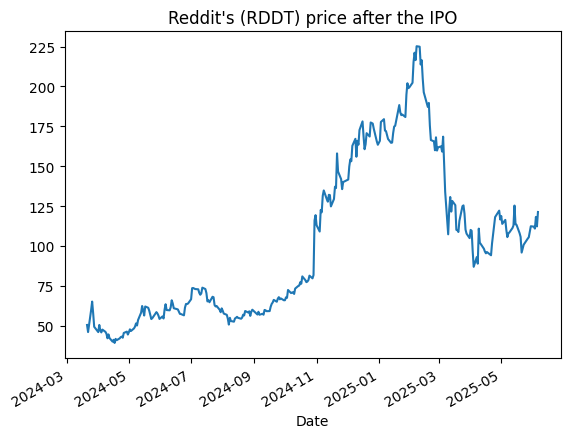

In [308]:
reddit['Close'].plot.line(title='Reddit\'s (RDDT) price after the IPO')

#2) OHLCV data transformations

## 2.1 [Code Snippet 2] Time series for OHLCV

In [309]:
ticker_obj = yf.Ticker("NVO")
nvo_df = ticker_obj.history(period = "max", interval = "1d")

In [310]:
# big plus of an API's data: good typing from the box!
# notice DatetimeIndex - it is a recognised date
nvo_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11117 entries, 1981-04-30 00:00:00-04:00 to 2025-06-06 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          11117 non-null  float64
 1   High          11117 non-null  float64
 2   Low           11117 non-null  float64
 3   Close         11117 non-null  float64
 4   Volume        11117 non-null  int64  
 5   Dividends     11117 non-null  float64
 6   Stock Splits  11117 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 694.8 KB


In [311]:
nvo_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-02 00:00:00-04:00,71.769997,72.849998,71.260002,72.830002,16807900,0.0,0.0
2025-06-03 00:00:00-04:00,71.599998,71.959999,70.580002,70.910004,8822700,0.0,0.0
2025-06-04 00:00:00-04:00,72.180000,73.139999,72.019997,72.040001,6917000,0.0,0.0
2025-06-05 00:00:00-04:00,73.139999,73.650002,72.320000,72.650002,5090500,0.0,0.0
2025-06-06 00:00:00-04:00,74.150002,75.160004,73.970001,74.629997,9537100,0.0,0.0


In [312]:
# filter on date (index)
nvo_df_filtered_from_2020 = nvo_df[nvo_df.index>='2020-01-01']
nvo_df_filtered_from_2024 = nvo_df[nvo_df.index>='2024-01-01']

<Axes: title={'center': 'Novo Nordisk A/S (NVO) price daily'}, xlabel='Date'>

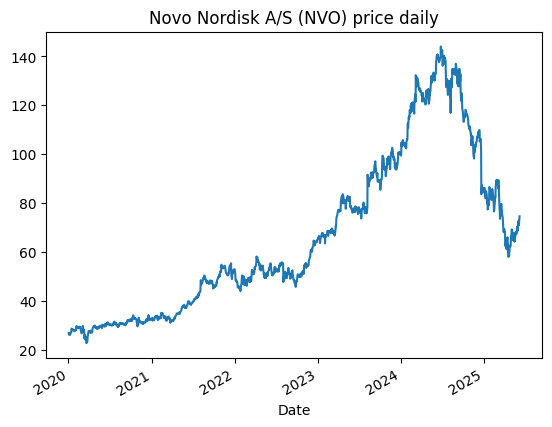

In [313]:
# Chaining: select one column, draw a plot, of a type line
nvo_df_filtered_from_2020['Close'].plot.line(title='Novo Nordisk A/S (NVO) price daily')

In [314]:
# Generating new fields (using DateTime features):

nvo_df['Ticker'] = 'NVO'
nvo_df['Year']= nvo_df.index.year
nvo_df['Month'] = nvo_df.index.month
nvo_df['Weekday'] = nvo_df.index.weekday
nvo_df['Date'] = nvo_df.index.date # to be used in joins

In [315]:
nvo_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,Weekday,Date
Date,,,,,,,,,,,,
2025-06-02 00:00:00-04:00,71.769997,72.849998,71.260002,72.830002,16807900,0.0,0.0,NVO,2025,6,0,2025-06-02
2025-06-03 00:00:00-04:00,71.599998,71.959999,70.580002,70.910004,8822700,0.0,0.0,NVO,2025,6,1,2025-06-03
2025-06-04 00:00:00-04:00,72.180000,73.139999,72.019997,72.040001,6917000,0.0,0.0,NVO,2025,6,2,2025-06-04
2025-06-05 00:00:00-04:00,73.139999,73.650002,72.320000,72.650002,5090500,0.0,0.0,NVO,2025,6,3,2025-06-05
2025-06-06 00:00:00-04:00,74.150002,75.160004,73.970001,74.629997,9537100,0.0,0.0,NVO,2025,6,4,2025-06-06


In [316]:
# shift ALL values (on x periods forward (+1) and backward (-1))
# equivalent of joining with a dataframe of the same vector, but with shifted date index
nvo_df['close_minus_1'] = nvo_df['Close'].shift(1) # Reversing the direction from previous
nvo_df['close_plus_1'] = nvo_df['Close'].shift(-1)

nvo_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,Weekday,Date,close_minus_1,close_plus_1
Date,,,,,,,,,,,,,,
2025-06-02 00:00:00-04:00,71.769997,72.849998,71.260002,72.830002,16807900,0.0,0.0,NVO,2025,6,0,2025-06-02,71.500000,70.910004
2025-06-03 00:00:00-04:00,71.599998,71.959999,70.580002,70.910004,8822700,0.0,0.0,NVO,2025,6,1,2025-06-03,72.830002,72.040001
2025-06-04 00:00:00-04:00,72.180000,73.139999,72.019997,72.040001,6917000,0.0,0.0,NVO,2025,6,2,2025-06-04,70.910004,72.650002
2025-06-05 00:00:00-04:00,73.139999,73.650002,72.320000,72.650002,5090500,0.0,0.0,NVO,2025,6,3,2025-06-05,72.040001,74.629997
2025-06-06 00:00:00-04:00,74.150002,75.160004,73.970001,74.629997,9537100,0.0,0.0,NVO,2025,6,4,2025-06-06,72.650002,NaN


In [317]:
# historical growth
nvo_df['growth_1d'] = nvo_df['Close'] / nvo_df['Close'].shift(1)           # nvo_df['close_plus_1']
nvo_df['growth_30d'] = nvo_df['Close'] / nvo_df['Close'].shift(30)

# FUTURE Growth : for regression models
nvo_df['growth_future_1d'] = nvo_df['Close'].shift(-1) / nvo_df['Close']   # nvo_df['close_minus_1']
nvo_df['growth_future_30d'] = nvo_df['Close'].shift(-30) / nvo_df['Close']   # nvo_df['close_minus_1']


# FUTURE Growth: for binary models
nvo_df['is_positive_growth_1d_future'] = np.where(nvo_df['growth_future_1d'] > 1, 1, 0) #  np.where(condition, value_if_true, value_if_false) ..so if greather than 1 then 1 else 0
nvo_df['is_positive_growth_30d_future'] = np.where(nvo_df['growth_future_30d'] > 1, 1, 0)


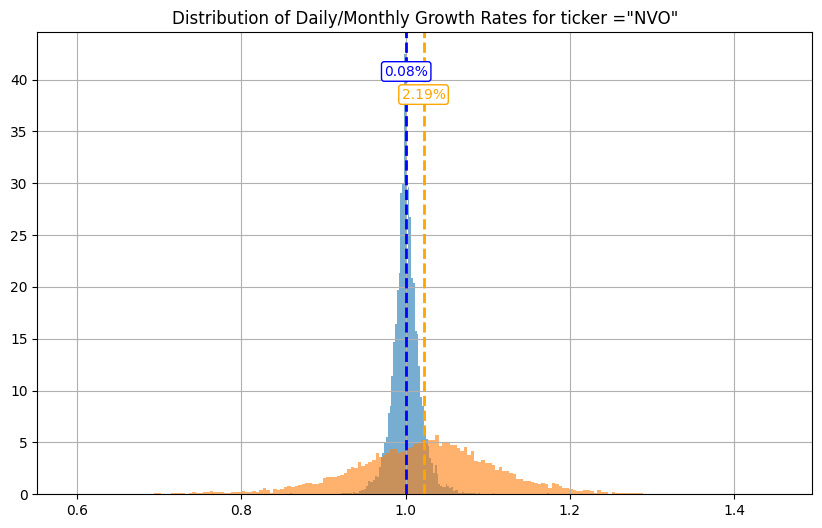

In [318]:
# normally the growth in 1 day is +-10%, while a lot of it is around 0% (around 1.)
plt.figure(figsize=(10, 6))
plt.title('Distribution of Daily/Monthly Growth Rates for ticker ="NVO"')

nvo_df.growth_1d.hist(bins=200, alpha=0.6, density=True)
nvo_df.growth_30d.hist(bins=200, alpha=0.6, density=True)

# Add vertical lines for averages
mean_1d = nvo_df.growth_1d.mean()
mean_30d = nvo_df.growth_30d.mean()

plt.axvline(mean_1d, color='blue', linestyle='--', linewidth=2, label=f'1d avg = {mean_1d:.3f}')
plt.axvline(mean_30d, color='orange', linestyle='--', linewidth=2, label=f'30d avg = {mean_30d:.3f}')


# Add mean text labels (as percent change)
ymax = plt.ylim()[1]
plt.text(mean_1d, ymax * 0.90,
         f'{(mean_1d - 1) * 100:.2f}%',
         color='blue', ha='center', va='bottom',
         bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.2'))

plt.text(mean_30d, ymax * 0.85,
         f'{(mean_30d - 1) * 100:.2f}%',
         color='orange', ha='center', va='bottom',
         bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.2'))


plt.show()

<Axes: title={'center': 'Distribution of 2-days Growth Rates for ticker = "NVO"'}>

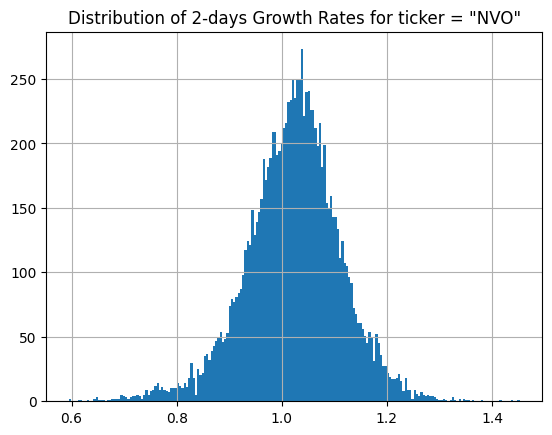

In [319]:
# you can see that the growth is can be much wider in 30 days (+- 30%)
plt.title('Distribution of 2-days Growth Rates for ticker = "NVO"')

nvo_df.growth_30d.hist(bins=200)

In [320]:
# for modeling: we use growth_1d, growth_2d as feature
COLUMNS = [k for k in nvo_df.keys() if k.find('growth')>=0 or k=='Close']
nvo_df[COLUMNS].tail()

,Close,growth_1d,growth_30d,growth_future_1d,growth_future_30d,is_positive_growth_1d_future,is_positive_growth_30d_future
Date,,,,,,,
2025-06-02 00:00:00-04:00,72.830002,1.018601,1.253960,0.973637,NaN,0,0
2025-06-03 00:00:00-04:00,70.910004,0.973637,1.215669,1.015936,NaN,1,0
2025-06-04 00:00:00-04:00,72.040001,1.015936,1.202470,1.008468,NaN,1,0
2025-06-05 00:00:00-04:00,72.650002,1.008468,1.185155,1.027254,NaN,1,0
2025-06-06 00:00:00-04:00,74.629997,1.027254,1.191601,NaN,NaN,0,0


In [321]:
# Calculate the distribution if future growth
nvo_df.is_positive_growth_1d_future.value_counts() / len(nvo_df)

,count
is_positive_growth_1d_future,
0,0.512908
1,0.487092


In [322]:
nvo_df.is_positive_growth_30d_future.value_counts() / len(nvo_df)

,count
is_positive_growth_30d_future,
1,0.619772
0,0.380228


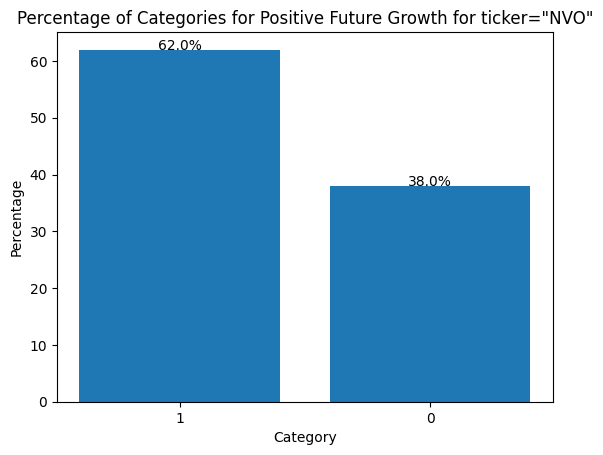

In [323]:
# Calculate value counts
value_counts = nvo_df['is_positive_growth_30d_future'].value_counts()

# Calculate percentage of each category
percentage = (value_counts / len(nvo_df)) * 100

# Plot as a bar chart
plt.bar(percentage.index.astype(str), percentage)
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title('Percentage of Categories for Positive Future Growth for ticker="NVO"')

# Add percentage values on top of each bar
for i, value in enumerate(percentage):
    plt.text(i, value + 0, f'{value:.1f}%', ha='center')

plt.show()

## 2.2) [Code Snippet 6] Candlestick chart for OHLCV

In [324]:
# Candlestick charts : https://plotly.com/python/candlestick-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=nvo_df_filtered_from_2020.index,
                open=nvo_df_filtered_from_2020.Open,
                high=nvo_df_filtered_from_2020.High,
                low=nvo_df_filtered_from_2020.Low,
                close=nvo_df_filtered_from_2020.Close)
               ])

fig.update_layout(
    title="NVO's daily candlestick chart from 2020",
    title_x=0.5,  # Set title x-position to center
    xaxis_rangeslider_visible=True
    )

fig.show()

In [325]:
fig = go.Figure(data=[go.Candlestick(x=nvo_df_filtered_from_2024.index,
                open=nvo_df_filtered_from_2024.Open,
                high=nvo_df_filtered_from_2024.High,
                low=nvo_df_filtered_from_2024.Low,
                close=nvo_df_filtered_from_2024.Close)
               ])

fig.update_layout(
    title="NVO's daily candlestick chart from 2024",
    title_x=0.5,  # Set title x-position to center
    xaxis_rangeslider_visible=True
    )

fig.show()

# 3) Macro Indicators

## 3.0) Previous indicators from module 1

In [326]:
end = date.today()
print(f'Year = {end.year}; month= {end.month}; day={end.day}')

start = date(year=end.year-70, month=end.month, day=end.day)
print(f'Period for indexes: {start} to {end} ')

Year = 2025; month= 6; day=7
Period for indexes: 1955-06-07 to 2025-06-07 


In [327]:
# reuse code for ealier covered indicators
ticker_obj = yf.Ticker("^GDAXI")
dax_daily = ticker_obj.history(period = "max", interval = "1d")

In [328]:
for i in [1,3,7,30,90,365]:
  #DEBUG: dax_daily['Adj Close_sh_m_'+str(i)+'d'] = dax_daily['Adj Close'].shift(i)
  dax_daily['growth_dax_'+str(i)+'d'] = dax_daily['Close'] / dax_daily['Close'].shift(i)

In [329]:
dax_daily.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,,,,,,,,
1987-12-30 00:00:00+01:00,1005.190002,1005.190002,1005.190002,1005.190002,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1988-01-04 00:00:00+01:00,956.489990,956.489990,956.489990,956.489990,0,0.0,0.0,0.951551,NaN,NaN,NaN,NaN,NaN
1988-01-05 00:00:00+01:00,996.099976,996.099976,996.099976,996.099976,0,0.0,0.0,1.041412,NaN,NaN,NaN,NaN,NaN
1988-01-06 00:00:00+01:00,1006.010010,1006.010010,1006.010010,1006.010010,0,0.0,0.0,1.009949,1.000816,NaN,NaN,NaN,NaN
1988-01-07 00:00:00+01:00,1014.469971,1014.469971,1014.469971,1014.469971,0,0.0,0.0,1.008409,1.060617,NaN,NaN,NaN,NaN


In [330]:
dax_daily.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,,,,,,,,
2025-06-05 00:00:00+02:00,24281.210938,24479.419922,24220.710938,24323.580078,53665700,0.0,0.0,1.001940,1.016419,1.004008,1.107532,1.142908,1.455963
2025-06-06 00:00:00+02:00,24304.369141,24355.029297,24214.529297,24304.460938,41235800,0.0,0.0,0.999214,1.008835,1.011077,1.101518,1.134102,1.451700


In [331]:
GROWTH_KEYS = [k for k in dax_daily.keys() if k.startswith('growth')]
dax_daily_to_merge = dax_daily[GROWTH_KEYS]
dax_daily_to_merge.tail(1)

,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,
2025-06-06 00:00:00+02:00,0.999214,1.008835,1.011077,1.101518,1.134102,1.4517


In [332]:
def get_growth_df(df:pd.DataFrame, prefix:str)->pd.DataFrame:
  for i in [1,3,7,30,90,365]:
    df['growth_'+prefix+'_'+str(i)+'d'] = df['Close'] / df['Close'].shift(i)
    GROWTH_KEYS = [k for k in df.keys() if k.startswith('growth')]
  return df[GROWTH_KEYS]

In [333]:
# https://finance.yahoo.com/quote/%5EGSPC/
# SNP - SNP Real Time Price. Currency in USD
ticker_obj = yf.Ticker("^GSPC")

# snp500_daily = yf.download(tickers = "^GSPC",
#                      period = "max",
#                      interval = "1d")

snp500_daily = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [334]:
snp500_to_merge = get_growth_df(snp500_daily,'snp500')
snp500_to_merge.tail(2)

,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
Date,,,,,,
2025-06-05 00:00:00-04:00,0.994723,1.000566,1.002999,1.104809,0.987862,1.245562
2025-06-06 00:00:00-04:00,1.010281,1.005023,1.018988,1.094004,0.988902,1.277121


In [335]:
# Dow Jones Industrial Average: https://finance.yahoo.com/quote/%5EDJI?.tsrc=fin-srch

ticker_obj = yf.Ticker("^DJI")

# dji_daily = yf.download(tickers = "^DJI",
#                      period = "max",
#                      interval = "1d")


dji_daily = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [336]:
dji_daily_to_merge = get_growth_df(dji_daily,'dji')
dji_daily_to_merge.tail(2)

,growth_dji_1d,growth_dji_3d,growth_dji_7d,growth_dji_30d,growth_dji_90d,growth_dji_365d
Date,,,,,,
2025-06-05 00:00:00-04:00,0.997454,1.000337,0.999435,1.068503,0.946463,1.126786
2025-06-06 00:00:00-04:00,1.010471,1.005720,1.015777,1.066581,0.953457,1.153198


In [337]:
# ETFs
# WisdomTree India Earnings Fund (EPI)
# NYSEArca - Nasdaq Real Time Price. Currency in USD
# WEB: https://finance.yahoo.com/quote/EPI/history?p=EPI

# epi_etf_daily = yf.download(tickers = "EPI",
#                      period = "max",
#                      interval = "1d")

ticker_obj = yf.Ticker("EPI")
epi_etf_daily = ticker_obj.history(
                     period = "max",
                     interval = "1d")

epi_etf_daily.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2025-06-05 00:00:00-04:00,46.259998,46.27,46.110001,46.139999,654900,0.0,0.0,0.0
2025-06-06 00:00:00-04:00,46.630001,46.77,46.630001,46.689999,477200,0.0,0.0,0.0


In [338]:
epi_etf_daily_to_merge = get_growth_df(epi_etf_daily,'epi')
epi_etf_daily_to_merge.tail(2)

,growth_epi_1d,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d
Date,,,,,,
2025-06-05 00:00:00-04:00,1.002825,0.991405,0.993326,1.026702,1.073523,1.131368
2025-06-06 00:00:00-04:00,1.011920,1.013898,1.008859,1.024802,1.092675,1.184242


In [339]:
# Real Potential Gross Domestic Product (GDPPOT), Billions of Chained 2012 Dollars, QUARTERLY
# https://fred.stlouisfed.org/series/GDPPOT
gdppot = pdr.DataReader("GDPPOT", "fred", start=start)
gdppot['gdppot_us_yoy'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(4)-1
gdppot['gdppot_us_qoq'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(1)-1
gdppot.tail(2)

,GDPPOT,gdppot_us_yoy,gdppot_us_qoq
DATE,,,
2025-01-01,23243.22,0.023113,0.005619
2025-04-01,23376.07,0.023029,0.005716


In [340]:
gdppot_to_merge = gdppot[['gdppot_us_yoy','gdppot_us_qoq']]
gdppot_to_merge.tail(1)

,gdppot_us_yoy,gdppot_us_qoq
DATE,,
2025-04-01,0.023029,0.005716


In [341]:
# # "Core CPI index", MONTHLY
# https://fred.stlouisfed.org/series/CPILFESL
# The "Consumer Price Index for All Urban Consumers: All Items Less Food & Energy"
# is an aggregate of prices paid by urban consumers for a typical basket of goods, excluding food and energy.
# This measurement, known as "Core CPI," is widely used by economists because food and energy have very volatile prices.
cpilfesl = pdr.DataReader("CPILFESL", "fred", start=start)
cpilfesl['cpi_core_yoy'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(12)-1
cpilfesl['cpi_core_mom'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(1)-1

cpilfesl.tail(2)

,CPILFESL,cpi_core_yoy,cpi_core_mom
DATE,,,
2025-03-01,325.659,0.028087,0.000565
2025-04-01,326.430,0.027815,0.002368


In [342]:
cpilfesl_to_merge = cpilfesl[['cpi_core_yoy','cpi_core_mom']]
cpilfesl_to_merge.tail(2)

,cpi_core_yoy,cpi_core_mom
DATE,,
2025-03-01,0.028087,0.000565
2025-04-01,0.027815,0.002368


In [343]:
# Fed rate https://fred.stlouisfed.org/series/FEDFUNDS
fedfunds = pdr.DataReader("FEDFUNDS", "fred", start=start)
fedfunds.tail(2)

,FEDFUNDS
DATE,
2025-04-01,4.33
2025-05-01,4.33


In [344]:
# https://fred.stlouisfed.org/series/DGS1
dgs1 = pdr.DataReader("DGS1", "fred", start=start)
dgs1.tail(2)

,DGS1
DATE,
2025-06-04,4.06
2025-06-05,4.08


In [345]:
# https://fred.stlouisfed.org/series/DGS5
dgs5 = pdr.DataReader("DGS5", "fred", start=start)
dgs5.tail(2)

,DGS5
DATE,
2025-06-04,3.93
2025-06-05,3.99


In [346]:
# https://fred.stlouisfed.org/series/DGS10
dgs10 = pdr.DataReader("DGS10", "fred", start=start)
dgs10.tail(2)

,DGS10
DATE,
2025-06-04,4.37
2025-06-05,4.40


## 3.1) [Code snippet 3] VIX - Volatility Index

In [347]:
# VIX - Volatility Index
# https://finance.yahoo.com/quote/%5EVIX/

ticker_obj = yf.Ticker("^VIX")

# vix = yf.download(tickers = "^VIX",
#                      period = "max",
#                      interval = "1d")

vix = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [348]:
vix.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-05 00:00:00-05:00,17.68,18.799999,17.08,18.48,0,0.0,0.0
2025-06-06 00:00:00-05:00,18.16,18.350000,16.65,16.77,0,0.0,0.0


In [349]:
vix_to_merge = vix['Close']
vix_to_merge.tail()

,Close
Date,
2025-06-02 00:00:00-05:00,18.360001
2025-06-03 00:00:00-05:00,17.690001
2025-06-04 00:00:00-05:00,17.610001
2025-06-05 00:00:00-05:00,18.480000
2025-06-06 00:00:00-05:00,16.770000


<Axes: title={'center': 'VIX value over time'}, xlabel='Date'>

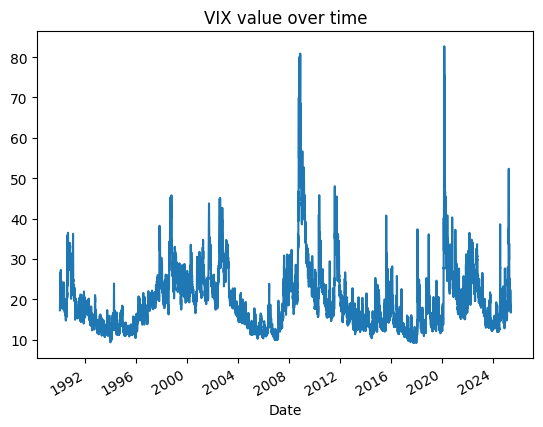

In [350]:
# Static graphs: hard to zoom in and get the exact dates of spikes
vix['Close'].plot.line(title = "VIX value over time")

In [351]:
# Dynamic visualisation of VIX prices
fig = px.line(vix,
              x=vix.index,
              y="Close",
              title='VIX over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

## 3.2) Gold - other assets

In [352]:
# GOLD
# WEB: https://finance.yahoo.com/quote/GC%3DF

ticker_obj = yf.Ticker("GC=F")

# gold = yf.download(tickers = "GC=F",
#                      period = "max",
#                      interval = "1d")

gold = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [353]:
gold.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-06 00:00:00-04:00,3364.300049,3364.300049,3306.0,3322.699951,731,0.0,0.0


In [354]:
gold_to_merge = get_growth_df(gold,'gold')
gold_to_merge.tail(2)

,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
Date,,,,,,
2025-06-05 00:00:00-04:00,0.993241,0.994096,1.015641,1.022709,1.224000,1.646940
2025-06-06 00:00:00-04:00,0.991644,0.991792,1.008835,0.997209,1.200918,1.629493


In [355]:
# Dynamic visualisation of GOLD prices
fig = px.line(gold,
              x=gold.index,
              y="Close",
              title='GOLD over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

## 3.3) WTI Crude and Brent Oil

In [356]:
# WTI Crude Oil
# WEB: https://uk.finance.yahoo.com/quote/CL=F/

ticker_obj = yf.Ticker("CL=F")

# crude_oil = yf.download(tickers = "CL=F",
#                      period = "max",
#                      interval = "1d")

crude_oil = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [357]:
crude_oil.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-05 00:00:00-04:00,62.759998,63.980000,62.50,63.369999,232423,0.0,0.0
2025-06-06 00:00:00-04:00,63.330002,64.800003,62.82,64.580002,232423,0.0,0.0


In [358]:
crude_oil_to_merge = get_growth_df(crude_oil,'wti_oil')
crude_oil_to_merge.tail(2)

,growth_wti_oil_1d,growth_wti_oil_3d,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d
Date,,,,,,
2025-06-05 00:00:00-04:00,1.008274,1.013596,1.040729,1.017665,0.866065,0.853813
2025-06-06 00:00:00-04:00,1.019094,1.018451,1.044308,1.028508,0.875424,0.874002


In [359]:
# Dynamic visualisation
fig = px.line(crude_oil,
              x=crude_oil.index,
              y="Close",
              title='WTI Crude Oil over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

In [360]:
# Brent Oil
# WEB: https://uk.finance.yahoo.com/quote/BZ=F/

ticker_obj = yf.Ticker("BZ=F")

# brent_oil = yf.download(tickers = "BZ=F",
#                      period = "max",
#                      interval = "1d")

brent_oil = ticker_obj.history(
                     period = "max",
                     interval = "1d")

brent_oil.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-05 00:00:00-04:00,64.910004,65.860001,64.629997,65.339996,38658,0.0,0.0
2025-06-06 00:00:00-04:00,65.199997,66.669998,64.820000,66.470001,38658,0.0,0.0


In [361]:
brent_oil_to_merge = get_growth_df(brent_oil,'brent_oil')
brent_oil_to_merge.tail(2)

,growth_brent_oil_1d,growth_brent_oil_3d,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d
Date,,,,,,
2025-06-05 00:00:00-04:00,1.007400,1.010986,1.019504,0.988203,0.847691,0.819824
2025-06-06 00:00:00-04:00,1.017294,1.012799,1.024191,0.998798,0.857788,0.837259


In [362]:
# Dynamic visualisation
fig = px.line(brent_oil,
              x=brent_oil.index,
              y="Close",
              title='Brent Oil over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()


## 3.4) Bitcoin prices: BTC_USD

In [363]:
# https://finance.yahoo.com/quote/BTC-USD/

ticker_obj = yf.Ticker("BTC-USD")

# btc_usd =  yf.download(tickers = "BTC-USD",
#                      period = "max",
#                      interval = "1d")


btc_usd =  ticker_obj.history(
                     period = "max",
                     interval = "1d")

btc_usd.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-06 00:00:00+00:00,101574.367188,105376.773438,101169.570312,104390.343750,48856653697,0.0,0.0
2025-06-07 00:00:00+00:00,104391.664062,105814.367188,104067.367188,105529.429688,42187026432,0.0,0.0


In [364]:
btc_usd_to_merge = get_growth_df(btc_usd,'btc_usd')
btc_usd_to_merge.tail(2)

,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
Date,,,,,,
2025-06-06 00:00:00+00:00,1.027707,0.990116,1.003767,1.075831,1.211663,1.475333
2025-06-07 00:00:00+00:00,1.010912,1.007614,1.008518,1.022161,1.309281,1.521856


In [365]:
# Dynamic visualisation
fig = px.line(btc_usd,
              x=btc_usd.index,
              y="Close",
              title='Bitcoin price daily')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()


## 3.5 [Code snippet 4] Eurostat: "The home of high-quality statistics and data on Europe"


In [366]:
!pip install eurostat

# https://pypi.org/project/eurostat/
# https://ec.europa.eu/eurostat/web/main/data/database

In [367]:
import eurostat

In [368]:
# LONG WAIT TIME ~15 min, unless you filter data

# https://ec.europa.eu/eurostat/cache/metadata/en/irt_euryld_esms.htm
  # Euro yield curves (irt_euryld)
  # Reference Metadata in Euro SDMX Metadata Structure (ESMS)
  # Compiling agency: Eurostat, the statistical office of the European Uni

# the service is slow, you need to specify addtional params : https://pypi.org/project/eurostat/0.2.3/

filter_pars = {'startPeriod':'2025-05-01', 'endPeriod':'2025-06-01'}

code = 'irt_euryld_d'
eurostat_euro_yield_df = eurostat.get_data_df(code, flags=True, filter_pars=filter_pars,  verbose=True)

Download progress: 100.0%



In [369]:
eurostat_euro_yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 47 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   freq              2148 non-null   object 
 1   yld_curv          2148 non-null   object 
 2   maturity          2148 non-null   object 
 3   bonds             2148 non-null   object 
 4   geo\TIME_PERIOD   2148 non-null   object 
 5   2025-05-02_value  2148 non-null   float64
 6   2025-05-02_flag   2148 non-null   object 
 7   2025-05-05_value  2148 non-null   float64
 8   2025-05-05_flag   2148 non-null   object 
 9   2025-05-06_value  2148 non-null   float64
 10  2025-05-06_flag   2148 non-null   object 
 11  2025-05-07_value  2148 non-null   float64
 12  2025-05-07_flag   2148 non-null   object 
 13  2025-05-08_value  2148 non-null   float64
 14  2025-05-08_flag   2148 non-null   object 
 15  2025-05-09_value  2148 non-null   float64
 16  2025-05-09_flag   2148 non-null   object 


In [370]:
eurostat_euro_yield_df.head()

,freq,yld_curv,maturity,bonds,geo\TIME_PERIOD,2025-05-02_value,2025-05-02_flag,2025-05-05_value,2025-05-05_flag,2025-05-06_value,...,2025-05-26_value,2025-05-26_flag,2025-05-27_value,2025-05-27_flag,2025-05-28_value,2025-05-28_flag,2025-05-29_value,2025-05-29_flag,2025-05-30_value,2025-05-30_flag
0,D,INS_FWD,M10,CGB_EA,EA,1.73842,,1.75209,,1.73532,...,1.71428,,1.71732,,1.73586,,1.70104,,1.73912,
1,D,INS_FWD,M10,CGB_EA_AAA,EA,1.69567,,1.68046,,1.70880,...,1.71962,,1.71396,,1.73539,,1.71651,,1.72649,
2,D,INS_FWD,M11,CGB_EA,EA,1.73363,,1.74807,,1.73333,...,1.71798,,1.72237,,1.73990,,1.70527,,1.74145,
3,D,INS_FWD,M11,CGB_EA_AAA,EA,1.68855,,1.67297,,1.70111,...,1.71803,,1.71302,,1.73309,,1.71424,,1.72509,
4,D,INS_FWD,M3,CGB_EA,EA,1.97791,,1.96619,,1.96325,...,1.94160,,1.93798,,1.94852,,1.93120,,1.93735,


In [371]:
eurostat_euro_yield_df['bonds'].value_counts()

,count
bonds,
CGB_EA,1074
CGB_EA_AAA,1074


In [372]:
eurostat_euro_yield_df['maturity'].value_counts()


,count
maturity,
Y9_M9,6
M10,6
M11,6
M3,6
M4,6
...,...
Y10,6
Y1,6
M9,6


In [373]:
eurostat_euro_yield_df['yld_curv'].value_counts()

,count
yld_curv,
INS_FWD,716
PAR,716
SPOT_RT,716


In [374]:
eurostat_euro_yield_df

,freq,yld_curv,maturity,bonds,geo\TIME_PERIOD,2025-05-02_value,2025-05-02_flag,2025-05-05_value,2025-05-05_flag,2025-05-06_value,...,2025-05-26_value,2025-05-26_flag,2025-05-27_value,2025-05-27_flag,2025-05-28_value,2025-05-28_flag,2025-05-29_value,2025-05-29_flag,2025-05-30_value,2025-05-30_flag
0,D,INS_FWD,M10,CGB_EA,EA,1.73842,,1.75209,,1.73532,...,1.71428,,1.71732,,1.73586,,1.70104,,1.73912,
1,D,INS_FWD,M10,CGB_EA_AAA,EA,1.69567,,1.68046,,1.70880,...,1.71962,,1.71396,,1.73539,,1.71651,,1.72649,
2,D,INS_FWD,M11,CGB_EA,EA,1.73363,,1.74807,,1.73333,...,1.71798,,1.72237,,1.73990,,1.70527,,1.74145,
3,D,INS_FWD,M11,CGB_EA_AAA,EA,1.68855,,1.67297,,1.70111,...,1.71803,,1.71302,,1.73309,,1.71424,,1.72509,
4,D,INS_FWD,M3,CGB_EA,EA,1.97791,,1.96619,,1.96325,...,1.94160,,1.93798,,1.94852,,1.93120,,1.93735,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,D,SPOT_RT,Y9_M7,CGB_EA_AAA,EA,2.56000,,2.58380,,2.61680,...,2.63569,,2.60094,,2.61034,,2.57690,,2.57548,
2144,D,SPOT_RT,Y9_M8,CGB_EA,EA,3.09194,,3.11837,,3.15733,...,3.13756,,3.09442,,3.10789,,3.06678,,3.07015,
2145,D,SPOT_RT,Y9_M8,CGB_EA_AAA,EA,2.56737,,2.59130,,2.62451,...,2.64314,,2.60802,,2.61738,,2.58400,,2.58254,
2146,D,SPOT_RT,Y9_M9,CGB_EA,EA,3.10140,,3.12818,,3.16710,...,3.14705,,3.10358,,3.11705,,3.07587,,3.07933,


In [375]:
# Visual graph: https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
FILTER = (eurostat_euro_yield_df.yld_curv=='SPOT_RT')& (eurostat_euro_yield_df.bonds=='CGB_EA_AAA')
filtered_eurostat_euro_yield_df = eurostat_euro_yield_df[FILTER]

In [376]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity')[['maturity','2025-05-05_value']].head(20)

,maturity,2025-05-05_value
1433,M10,1.79463
1435,M11,1.78389
1437,M3,1.91227
1439,M4,1.89037
1441,M5,1.87031
1443,M6,1.85200
1445,M7,1.83535
1447,M8,1.82029
1449,M9,1.80674
1451,Y1,1.77444


In [377]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity')[['maturity','2025-05-29_value']].head(20)

,maturity,2025-05-29_value
1433,M10,1.78884
1435,M11,1.78214
1437,M3,1.86951
1439,M4,1.85393
1441,M5,1.83981
1443,M6,1.82708
1445,M7,1.81569
1447,M8,1.80555
1449,M9,1.79662
1451,Y1,1.77647


In [378]:
import re

def extract_numbers(input_string):
    y_match = re.search(r'Y(\d+)', input_string)
    m_match = re.search(r'M(\d+)', input_string)

    y_number = int(y_match.group(1)) if y_match else 0
    m_number = int(m_match.group(1)) if m_match else 0


    return y_number*12 + m_number

# Examples
examples = ["Y10_M2", "M3", "Y1"]
for example in examples:
    res = extract_numbers(example)
    print(f"{example} ==> {res}")

Y10_M2 ==> 122
M3 ==> 3
Y1 ==> 12


In [379]:
# define new field: "maturity in months"
filtered_eurostat_euro_yield_df.loc[:,'maturity_in_months'] = filtered_eurostat_euro_yield_df.maturity.apply(lambda x:extract_numbers(x))

In [380]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity_in_months')[['maturity','maturity_in_months','2025-05-29_value']].head(20)

,maturity,maturity_in_months,2025-05-29_value
1437,M3,3,1.86951
1439,M4,4,1.85393
1441,M5,5,1.83981
1443,M6,6,1.82708
1445,M7,7,1.81569
1447,M8,8,1.80555
1449,M9,9,1.79662
1433,M10,10,1.78884
1435,M11,11,1.78214
1451,Y1,12,1.77647


In [381]:
filtered_eurostat_euro_yield_df.loc[:,'maturity_in_years'] = filtered_eurostat_euro_yield_df.maturity_in_months/12.0

<Axes: title={'center': 'AAA rated bonds spot yield curve'}, xlabel='maturity_in_years'>

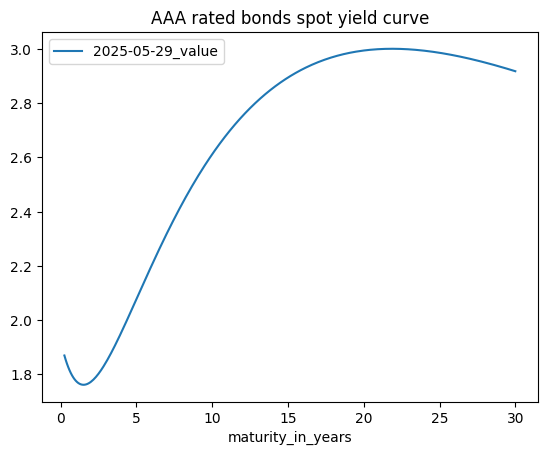

In [382]:
# exactly the same as on the Web:  https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
filtered_eurostat_euro_yield_df \
  .sort_values(by='maturity_in_months')[['maturity_in_years','2025-05-29_value']] \
  .plot.line(x='maturity_in_years',
            y='2025-05-29_value',
            title='AAA rated bonds spot yield curve')

# 4) [Code Snippet 5] Fundamental indicators

* Read about "Ratio Analysis" to learn about more ratios: https://www.investopedia.com/terms/r/ratioanalysis.asp
* https://algotrading101.com/learn/yahoo-finance-api-guide/

In [383]:
# let's select some set of stocks: e.g. top US companies on 'Employees':
# https://companiesmarketcap.com/usa/largest-american-companies-by-number-of-employees/

US_TOP_EMPLOYEES_STOCKS = ['WMT','AMZN','UPS','HD','CNXC','TGT','KR','UNH','BRK-B','SBUX']

# WMT
ticker = US_TOP_EMPLOYEES_STOCKS[0]

# WMT ticker
one_company = yf.Ticker(ticker)

In [384]:
# Fundamental info appears close earning dates, you need to download it and use quickly (before/after trading day),
#  unless you're a fundamental long-term investor looking for a several months-quarters-years strategy (period between buy and sell)
# This dfthis is the easiest thing to join with the main dataset and get "some" technical indicators present
# WMT ticker
eps_earnings = one_company.earnings_dates
eps_earnings['Ticker'] = ticker
eps_earnings

,EPS Estimate,Reported EPS,Surprise(%),Ticker
Earnings Date,,,,
2026-05-13 09:30:00-04:00,NaN,NaN,NaN,WMT
2026-02-19 09:30:00-05:00,NaN,NaN,NaN,WMT
2025-11-20 09:30:00-05:00,NaN,NaN,NaN,WMT
2025-08-21 09:30:00-04:00,NaN,NaN,NaN,WMT
2025-05-15 07:01:00-04:00,0.58,0.61,5.93,WMT
2025-02-20 06:59:00-05:00,0.64,0.66,2.57,WMT
2024-11-19 07:00:00-05:00,0.53,0.58,8.82,WMT
2024-08-15 07:02:00-04:00,0.65,0.67,3.78,WMT
2024-05-16 07:01:00-04:00,0.52,0.60,14.60,WMT


In [385]:
one_company.calendar

{'Dividend Date': datetime.date(2026, 1, 5),
 'Ex-Dividend Date': datetime.date(2025, 8, 15),
 'Earnings Date': [datetime.date(2025, 8, 21)],
 'Earnings High': 0.8,
 'Earnings Low': 0.67,
 'Earnings Average': 0.7236,
 'Revenue High': 176653000000,
 'Revenue Low': 172272000000,
 'Revenue Average': 174049148760}

In [386]:
one_company.financials

,2025-01-31,2024-01-31,2023-01-31,2022-01-31,2021-01-31
Tax Effect Of Unusual Items,0.0,0.0,0.0,-612140000.0,NaN
Tax Rate For Calcs,0.234,0.255,0.336,0.254,NaN
Normalized EBITDA,42010000000.0,36384000000.0,30089000000.0,33758000000.0,NaN
Total Unusual Items,NaN,0.0,0.0,-2410000000.0,0.0
Total Unusual Items Excluding Goodwill,NaN,0.0,0.0,-2410000000.0,0.0
Net Income From Continuing Operation Net Minority Interest,19436000000.0,15511000000.0,11680000000.0,13673000000.0,NaN
Reconciled Depreciation,12973000000.0,11853000000.0,10945000000.0,10658000000.0,NaN
Reconciled Cost Of Revenue,511753000000.0,490142000000.0,463721000000.0,429000000000.0,NaN
EBITDA,42010000000.0,36384000000.0,30089000000.0,31348000000.0,NaN
EBIT,29037000000.0,24531000000.0,19144000000.0,20690000000.0,NaN


In [387]:
EPS = one_company.financials.loc['Basic EPS']
EPS

,Basic EPS
2025-01-31,2.42
2024-01-31,1.92
2023-01-31,1.43
2022-01-31,1.633333
2021-01-31,NaN


In [388]:
# or should we use NORMALIZED_EBITDA?
EBITDA = one_company.financials.loc['EBITDA']
EBITDA_margin = one_company.financials.loc['EBITDA'] /  one_company.financials.loc['Total Revenue']

In [389]:
EBITDA_margin

,0
2025-01-31,0.06169
2024-01-31,0.056137
2023-01-31,0.049222
2022-01-31,0.054732
2021-01-31,NaN


In [390]:
NET_INCOME = one_company.financials.loc['Net Income']
NET_INCOME_margin = one_company.financials.loc['Net Income'] /  one_company.financials.loc['Total Revenue']

In [391]:
NET_INCOME

,Net Income
2025-01-31,19436000000.0
2024-01-31,15511000000.0
2023-01-31,11680000000.0
2022-01-31,13673000000.0
2021-01-31,NaN


In [392]:
# Compare with Public information - you can fully replicate the numbers (yearly and/or quarterly):
# https://www.wsj.com/market-data/quotes/WMT/financials/annual/income-statement
NET_INCOME_margin

,0
2025-01-31,0.028541
2024-01-31,0.023932
2023-01-31,0.019107
2022-01-31,0.023872
2021-01-31,NaN


In [393]:
# Combine the series into a DataFrame
df_fin_ratios = pd.DataFrame({
    'NET_INCOME_margin': 100.0 * NET_INCOME_margin, #for visualisation -- Margin in %
    'EBITDA_margin': 100.0 *EBITDA_margin, #for visualisation -- Margin in %
    'EPS': EPS
})

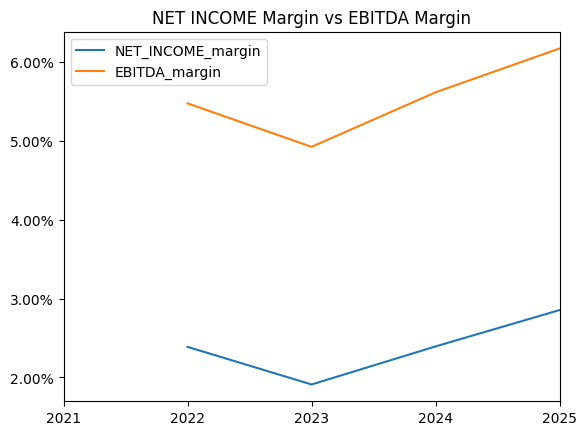

In [394]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Assuming df_fin_ratios is your DataFrame containing the financial ratios
# Make sure you have already created this DataFrame

# Plotting the specified columns
ax = df_fin_ratios[['NET_INCOME_margin','EBITDA_margin']].plot.line()

# Setting the y-axis formatter to display values as percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Adding title
plt.title('NET INCOME Margin vs EBITDA Margin')

# Displaying the plot
plt.show()

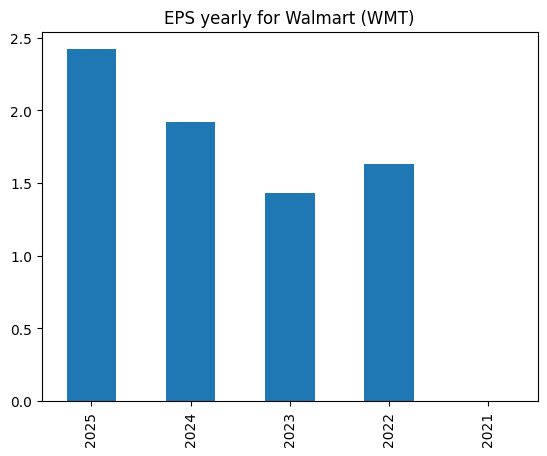

In [395]:
EPS_year = df_fin_ratios['EPS'].index.year

df_fin_ratios['EPS'].plot.bar(title = 'EPS yearly for Walmart (WMT)')

plt.xticks(range(len(EPS_year)), EPS_year)
# Displaying the plot
plt.show()

# 5) [Code snippet 7] Daily OHCLV data for a set of stocks

In [396]:
# https://companiesmarketcap.com/usa/largest-companies-in-the-usa-by-market-cap/
US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']

# You're required to add EU_STOCKS and INDIA_STOCS
# https://companiesmarketcap.com/european-union/largest-companies-in-the-eu-by-market-cap/
EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']

# https://companiesmarketcap.com/india/largest-companies-in-india-by-market-cap/
INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']

In [397]:
ALL_TICKERS = US_STOCKS  + EU_STOCKS + INDIA_STOCKS
ALL_TICKERS

['MSFT',
 'AAPL',
 'GOOG',
 'NVDA',
 'AMZN',
 'META',
 'BRK-B',
 'LLY',
 'AVGO',
 'V',
 'JPM',
 'NVO',
 'MC.PA',
 'ASML',
 'RMS.PA',
 'OR.PA',
 'SAP',
 'ACN',
 'TTE',
 'SIE.DE',
 'IDEXY',
 'CDI.PA',
 'RELIANCE.NS',
 'TCS.NS',
 'HDB',
 'BHARTIARTL.NS',
 'IBN',
 'SBIN.NS',
 'LICI.NS',
 'INFY',
 'ITC.NS',
 'HINDUNILVR.NS',
 'LT.NS']

In [398]:
import time

stocks_df = pd.DataFrame({'A' : []})

for i,ticker in enumerate(ALL_TICKERS):
  print(i,ticker)

  # Work with stock prices
  ticker_obj = yf.Ticker(ticker)

  # historyPrices = yf.download(tickers = ticker,
  #                    period = "max",
  #                    interval = "1d")
  historyPrices = ticker_obj.history(
                     period = "max",
                     interval = "1d")

  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns
  for i in [1,3,7,30,90,365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(i)
  historyPrices['growth_future_30d'] = historyPrices['Close'].shift(-5) / historyPrices['Close']

  # Technical indicators
  # SimpleMovingAverage 10 days and 20 days
  historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
  historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
  historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
  historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Close'].rolling(30).std() * np.sqrt(252)

  # what we want to predict
  historyPrices['is_positive_growth_30d_future'] = np.where(historyPrices['growth_future_30d'] > 1, 1, 0)

  # sleep 1 sec between downloads - not to overload the API server
  time.sleep(1)


  if stocks_df.empty:
    stocks_df = historyPrices
  else:
    stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)

0 MSFT
1 AAPL
2 GOOG
3 NVDA
4 AMZN
5 META
6 BRK-B
7 LLY
8 AVGO
9 V
10 JPM
11 NVO
12 MC.PA
13 ASML
14 RMS.PA
15 OR.PA
16 SAP
17 ACN
18 TTE
19 SIE.DE
20 IDEXY
21 CDI.PA
22 RELIANCE.NS
23 TCS.NS
24 HDB
25 BHARTIARTL.NS
26 IBN
27 SBIN.NS
28 LICI.NS
29 INFY
30 ITC.NS
31 HINDUNILVR.NS
32 LT.NS


In [399]:
def get_ticker_type(ticker:str, us_stocks_list, eu_stocks_list, india_stocks_list):
  if ticker in us_stocks_list:
    return 'US'
  elif ticker in eu_stocks_list:
    return 'EU'
  elif ticker in india_stocks_list:
    return 'INDIA'
  else:
    return 'ERROR'


In [400]:
stocks_df['ticker_type'] = stocks_df.Ticker.apply(lambda x:get_ticker_type(x, US_STOCKS, EU_STOCKS, INDIA_STOCKS))

In [401]:
# count of observations between US-EU-INDIA stocks
stocks_df.ticker_type.value_counts()

,count
ticker_type,
US,83709
EU,80078
INDIA,66310


In [402]:
# unique tickers
stocks_df.Ticker.nunique()

33

In [403]:
# count of observations by stock
stocks_df.Ticker.value_counts()

,count
Ticker,
LLY,13366
JPM,11400
AAPL,11212
NVO,11117
MSFT,9886
CDI.PA,8605
TTE,8464
ASML,7609
SAP,7480


In [404]:
stocks_df.groupby(['Ticker','ticker_type']).Date.agg(['min','max'])

,,min,max
Ticker,ticker_type,,
AAPL,US,1980-12-12,2025-06-06
ACN,EU,2001-07-19,2025-06-06
AMZN,US,1997-05-15,2025-06-06
ASML,EU,1995-03-15,2025-06-06
AVGO,US,2009-08-06,2025-06-06
BHARTIARTL.NS,INDIA,2002-07-01,2025-06-06
BRK-B,US,1996-05-09,2025-06-06
CDI.PA,EU,1992-01-27,2025-06-06
GOOG,US,2004-08-19,2025-06-06


In [405]:
#  average growth 365days
stocks_df[stocks_df.Year>=2020].groupby(by=['Year','ticker_type']).growth_365d.mean()

Year  ticker_type
2020  EU             1.239693
      INDIA          1.098703
      US             1.484070
2021  EU             1.579891
      INDIA          1.544755
      US             1.797571
2022  EU             1.191141
      INDIA          1.379350
      US             1.182379
2023  EU             1.247556
      INDIA          1.202550
      US             1.203253
2024  EU             1.407605
      INDIA          1.356211
      US             2.159361
2025  EU             1.173593
      INDIA          1.217306
      US             1.671300
Name: growth_365d, dtype: float64

In [406]:
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])

In [407]:
# filtering only on stats after 2000
stocks_df[stocks_df.Date>='2000-01-01'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 191630 entries, 3490 to 230096
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Open                           191630 non-null  float64       
 1   High                           191630 non-null  float64       
 2   Low                            191630 non-null  float64       
 3   Close                          191630 non-null  float64       
 4   Volume                         191630 non-null  int64         
 5   Dividends                      191630 non-null  float64       
 6   Stock Splits                   191630 non-null  float64       
 7   Ticker                         191630 non-null  object        
 8   Year                           191630 non-null  int32         
 9   Month                          191630 non-null  int32         
 10  Weekday                        191630 non-null  int32         
 11  Da

In [408]:
stocks_df[stocks_df.Date=='2025-04-01'].tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_90d,growth_365d,growth_future_30d,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility,is_positive_growth_30d_future,ticker_type
202975,795.000000,806.000000,792.099976,797.750000,726877,0.0,0.0,LICI.NS,2025,4,...,0.904530,1.249596,0.983767,786.810004,767.930005,1,0.017424,337.725353,0,INDIA
209575,18.190001,18.209999,17.950001,18.200001,13574900,0.0,0.0,INFY,2025,4,...,0.842593,1.105543,0.902198,18.432000,18.730500,0,0.014286,17.068021,0,INDIA
216965,402.386004,406.902788,398.262008,399.292999,15206240,0.0,0.0,ITC.NS,2025,4,...,0.903574,0.964762,1.014509,400.068704,398.897778,1,0.021640,69.909597,1,INDIA
224356,2259.000000,2284.649902,2220.000000,2233.850098,2495962,0.0,0.0,HINDUNILVR.NS,2025,4,...,0.937490,0.915983,1.024800,2237.069995,2215.125000,1,0.028941,691.003186,1,INDIA
230052,3447.844234,3469.244743,3398.306242,3405.043457,1935147,0.0,0.0,LT.NS,2025,4,...,0.986594,1.119635,0.919780,3377.198193,3277.881909,1,0.020833,1726.860104,0,INDIA


#6) [Code Snippet 8] Technical Indicators with TA-lib
* PythonInvest article on Tech. Indicators
* Code for generating 100+ tech. indicators/patterns : https://github.com/realmistic/PythonInvest-basic-fin-analysis/blob/master/colab_notebooks/Part14_Exploring_Tech_Indicators_For_Stocks_and_Crypto.ipynb

Indicator groups: https://github.com/TA-Lib/ta-lib-python/blob/master/README.md

* Overlap Studies (17)
* Momentum Indicators (30+)
* Volume Indicators (3)
* Cycle Indicators (5)
* Price Transform (4)
* Volatility Indicators (3)
* Pattern Recognition (60)

In [409]:
# https://stackoverflow.com/questions/49648391/how-to-install-ta-lib-in-google-colab
# Update (apr 2023): Colab is now Python 3.10
# there are some other (older) ways to install talib

# url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
# !curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
# url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
# !curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
# import talib

In [410]:
# [2025 way - seems to be working] https://medium.com/@Tobi_Lux/collaboration-of-colab-yfinance-and-ta-lib-recent-issues-6cd8eebb56b0
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
!pip install conda-package-handling
!wget https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
!cph x ta-lib-0.5.1-py311h9ecbd09_0.conda

# 🛠 Option 1: Remove the existing directory first (clean, but destructive)
!rm -rf /usr/local/lib/python3.11/dist-packages/talib

!mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4111    0  4111    0     0  15591      0 --:--:-- --:--:-- --:--:-- 15631
100  517k  100  517k    0     0   738k      0 --:--:-- --:--:-- --:--:-- 6100k
--2025-06-07 15:08:16--  https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
Resolving anaconda.org (anaconda.org)... 104.19.144.37, 104.19.145.37, 2606:4700::6813:9125, ...
Connecting to anaconda.org (anaconda.org)|104.19.144.37|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5f738b4b78d4370a69f82984/673b62920c609ff6945bb24d?response-content-disposition=attachment%3B%20filename%3D%22ta-lib-0.5.1-py311h9ecbd09_0.conda%22%3B%20filename%2A%3DUTF-8%27%27ta-lib-0.5.1-py311h9ecbd09_0.conda&response-content-type=application%2Foctet-stream&X-Amz-Algorithm=

## 6.1) Momentum indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/momentum_indicators.md

In [411]:
def talib_get_momentum_indicators_for_one_ticker(df: pd.DataFrame) -> pd.DataFrame:
  # ADX - Average Directional Movement Index
  talib_momentum_adx = talib.ADX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # ADXR - Average Directional Movement Index Rating
  talib_momentum_adxr = talib.ADXR(df.High.values, df.Low.values, df.Close.values, timeperiod=14 )
  # APO - Absolute Price Oscillator
  talib_momentum_apo = talib.APO(df.Close.values, fastperiod=12, slowperiod=26, matype=0 )
  # AROON - Aroon
  talib_momentum_aroon = talib.AROON(df.High.values, df.Low.values, timeperiod=14 )
  # talib_momentum_aroon[0].size
  # talib_momentum_aroon[1].size
  # AROONOSC - Aroon Oscillator
  talib_momentum_aroonosc = talib.AROONOSC(df.High.values, df.Low.values, timeperiod=14)
  # BOP - Balance of Power
  # https://school.stockcharts.com/doku.php?id=technical_indicators:balance_of_power
     #calculate open prices as shifted closed prices from the prev day
     # open = df.Last.shift(1)
  talib_momentum_bop = talib.BOP(df.Open.values, df.High.values, df.Low.values, df.Close.values)
  # CCI - Commodity Channel Index
  talib_momentum_cci = talib.CCI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # CMO - Chande Momentum Oscillator
  talib_momentum_cmo = talib.CMO(df.Close.values, timeperiod=14)
  # DX - Directional Movement Index
  talib_momentum_dx = talib.DX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # MACD - Moving Average Convergence/Divergence
  talib_momentum_macd, talib_momentum_macdsignal, talib_momentum_macdhist = talib.MACD(df.Close.values, fastperiod=12, \
                                                                                       slowperiod=26, signalperiod=9)
  # MACDEXT - MACD with controllable MA type
  talib_momentum_macd_ext, talib_momentum_macdsignal_ext, talib_momentum_macdhist_ext = talib.MACDEXT(df.Close.values, \
                                                                                                    fastperiod=12, \
                                                                                                    fastmatype=0, \
                                                                                                    slowperiod=26, \
                                                                                                    slowmatype=0, \
                                                                                                    signalperiod=9, \
                                                                                                  signalmatype=0)
  # MACDFIX - Moving Average Convergence/Divergence Fix 12/26
  talib_momentum_macd_fix, talib_momentum_macdsignal_fix, talib_momentum_macdhist_fix = talib.MACDFIX(df.Close.values, \
                                                                                                      signalperiod=9)
  # MFI - Money Flow Index
  talib_momentum_mfi = talib.MFI(df.High.values, df.Low.values, df.Close.values, df.Volume.values, timeperiod=14)
  # MINUS_DI - Minus Directional Indicator
  talib_momentum_minus_di = talib.MINUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # MOM - Momentum
  talib_momentum_mom = talib.MOM(df.Close.values, timeperiod=10)
  # PLUS_DI - Plus Directional Indicator
  talib_momentum_plus_di = talib.PLUS_DI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # PLUS_DM - Plus Directional Movement
  talib_momentum_plus_dm = talib.PLUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # PPO - Percentage Price Oscillator
  talib_momentum_ppo = talib.PPO(df.Close.values, fastperiod=12, slowperiod=26, matype=0)
  # ROC - Rate of change : ((price/prevPrice)-1)*100
  talib_momentum_roc = talib.ROC(df.Close.values, timeperiod=10)
  # ROCP - Rate of change Percentage: (price-prevPrice)/prevPrice
  talib_momentum_rocp = talib.ROCP(df.Close.values, timeperiod=10)
  # ROCR - Rate of change ratio: (price/prevPrice)
  talib_momentum_rocr = talib.ROCR(df.Close.values, timeperiod=10)
  # ROCR100 - Rate of change ratio 100 scale: (price/prevPrice)*100
  talib_momentum_rocr100 = talib.ROCR100(df.Close.values, timeperiod=10)
  # RSI - Relative Strength Index
  talib_momentum_rsi = talib.RSI(df.Close.values, timeperiod=14)
  # STOCH - Stochastic
  talib_momentum_slowk, talib_momentum_slowd = talib.STOCH(df.High.values, df.Low.values, df.Close.values, \
                                                           fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
  # STOCHF - Stochastic Fast
  talib_momentum_fastk, talib_momentum_fastd = talib.STOCHF(df.High.values, df.Low.values, df.Close.values, \
                                                            fastk_period=5, fastd_period=3, fastd_matype=0)
  # STOCHRSI - Stochastic Relative Strength Index
  talib_momentum_fastk_rsi, talib_momentum_fastd_rsi = talib.STOCHRSI(df.Close.values, timeperiod=14, \
                                                                      fastk_period=5, fastd_period=3, fastd_matype=0)
  # TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
  talib_momentum_trix = talib.TRIX(df.Close.values, timeperiod=30)
  # ULTOSC - Ultimate Oscillator
  talib_momentum_ultosc = talib.ULTOSC(df.High.values, df.Low.values, df.Close.values, timeperiod1=7, timeperiod2=14, timeperiod3=28)
  # WILLR - Williams' %R
  talib_momentum_willr = talib.WILLR(df.High.values, df.Low.values, df.Close.values, timeperiod=14)

  momentum_df =   pd.DataFrame(
    {
      # assume here multi-index <dateTime, ticker>
      # 'datetime': df.index.get_level_values(0),
      # 'ticker': df.index.get_level_values(1) ,

      # old way with separate columns
      'Date': df.Date.values,
      'Ticker': df.Ticker,

      'adx': talib_momentum_adx,
      'adxr': talib_momentum_adxr,
      'apo': talib_momentum_apo,
      'aroon_1': talib_momentum_aroon[0] ,
      'aroon_2': talib_momentum_aroon[1],
      'aroonosc': talib_momentum_aroonosc,
      'bop': talib_momentum_bop,
      'cci': talib_momentum_cci,
      'cmo': talib_momentum_cmo,
      'dx': talib_momentum_dx,
      'macd': talib_momentum_macd,
      'macdsignal': talib_momentum_macdsignal,
      'macdhist': talib_momentum_macdhist,
      'macd_ext': talib_momentum_macd_ext,
      'macdsignal_ext': talib_momentum_macdsignal_ext,
      'macdhist_ext': talib_momentum_macdhist_ext,
      'macd_fix': talib_momentum_macd_fix,
      'macdsignal_fix': talib_momentum_macdsignal_fix,
      'macdhist_fix': talib_momentum_macdhist_fix,
      'mfi': talib_momentum_mfi,
      'minus_di': talib_momentum_minus_di,
      'mom': talib_momentum_mom,
      'plus_di': talib_momentum_plus_di,
      'dm': talib_momentum_plus_dm,
      'ppo': talib_momentum_ppo,
      'roc': talib_momentum_roc,
      'rocp': talib_momentum_rocp,
      'rocr': talib_momentum_rocr,
      'rocr100': talib_momentum_rocr100,
      'rsi': talib_momentum_rsi,
      'slowk': talib_momentum_slowk,
      'slowd': talib_momentum_slowd,
      'fastk': talib_momentum_fastk,
      'fastd': talib_momentum_fastd,
      'fastk_rsi': talib_momentum_fastk_rsi,
      'fastd_rsi': talib_momentum_fastd_rsi,
      'trix': talib_momentum_trix,
      'ultosc': talib_momentum_ultosc,
      'willr': talib_momentum_willr,
     }
  )
  return momentum_df

## 6.2 Volume, Volatility, Cycle, Price indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md

In [412]:
def talib_get_volume_volatility_cycle_price_indicators(df: pd.DataFrame) -> pd.DataFrame:
        # TA-Lib Volume indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md
        # AD - Chaikin A/D Line
        talib_ad = talib.AD(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values)
        # ADOSC - Chaikin A/D Oscillator
        talib_adosc = talib.ADOSC(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values, fastperiod=3, slowperiod=10)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Volatility indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volatility_indicators.md
        # ATR - Average True Range
        talib_atr = talib.ATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # NATR - Normalized Average True Range
        talib_natr = talib.NATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Cycle Indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/cycle_indicators.md
        # HT_DCPERIOD - Hilbert Transform - Dominant Cycle Period
        talib_ht_dcperiod = talib.HT_DCPERIOD(df.Close.values)
        # HT_DCPHASE - Hilbert Transform - Dominant Cycle Phase
        talib_ht_dcphase = talib.HT_DCPHASE(df.Close.values)
        # HT_PHASOR - Hilbert Transform - Phasor Components
        talib_ht_phasor_inphase, talib_ht_phasor_quadrature = talib.HT_PHASOR(
            df.Close.values)
        # HT_SINE - Hilbert Transform - SineWave
        talib_ht_sine_sine, talib_ht_sine_leadsine = talib.HT_SINE(
            df.Close.values)
        # HT_TRENDMODE - Hilbert Transform - Trend vs Cycle Mode
        talib_ht_trendmode = talib.HT_TRENDMODE(df.Close.values)

        # TA-Lib Price Transform Functions
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/price_transform.md
        # AVGPRICE - Average Price
        talib_avgprice = talib.AVGPRICE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # MEDPRICE - Median Price
        talib_medprice = talib.MEDPRICE(df.High.values, df.Low.values)
        # TYPPRICE - Typical Price
        talib_typprice = talib.TYPPRICE(
            df.High.values, df.Low.values, df.Close.values)
        # WCLPRICE - Weighted Close Price
        talib_wclprice = talib.WCLPRICE(
            df.High.values, df.Low.values, df.Close.values)

        volume_volatility_cycle_price_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Volume indicators
             'ad': talib_ad,
             'adosc': talib_adosc,
             'obv': talib_obv,
             # TA-Lib Volatility indicators
             'atr': talib_atr,
             'natr': talib_natr,
             'obv': talib_obv,
             # TA-Lib Cycle Indicators
             'ht_dcperiod': talib_ht_dcperiod,
             'ht_dcphase': talib_ht_dcphase,
             'ht_phasor_inphase': talib_ht_phasor_inphase,
             'ht_phasor_quadrature': talib_ht_phasor_quadrature,
             'ht_sine_sine': talib_ht_sine_sine,
             'ht_sine_leadsine': talib_ht_sine_leadsine,
             'ht_trendmod': talib_ht_trendmode,
             # TA-Lib Price Transform Functions
             'avgprice': talib_avgprice,
             'medprice': talib_medprice,
             'typprice': talib_typprice,
             'wclprice': talib_wclprice,
             }
        )

        # Need a proper date type
        volume_volatility_cycle_price_df['Date'] = pd.to_datetime(
            volume_volatility_cycle_price_df['Date'])

        return volume_volatility_cycle_price_df

## 6.3) Pattern indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md

In [413]:
def talib_get_pattern_recognition_indicators(df: pd.DataFrame) -> pd.DataFrame:
# TA-Lib Pattern Recognition indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md
        # Nice article about candles (pattern recognition) https://medium.com/analytics-vidhya/recognizing-over-50-candlestick-patterns-with-python-4f02a1822cb5

        # CDL2CROWS - Two Crows
        talib_cdl2crows = talib.CDL2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3BLACKCROWS - Three Black Crows
        talib_cdl3blackrows = talib.CDL3BLACKCROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3INSIDE - Three Inside Up/Down
        talib_cdl3inside = talib.CDL3INSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3LINESTRIKE - Three-Line Strike
        talib_cdl3linestrike = talib.CDL3LINESTRIKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3OUTSIDE - Three Outside Up/Down
        talib_cdl3outside = talib.CDL3OUTSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3STARSINSOUTH - Three Stars In The South
        talib_cdl3starsinsouth = talib.CDL3STARSINSOUTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3WHITESOLDIERS - Three Advancing White Soldiers
        talib_cdl3whitesoldiers = talib.CDL3WHITESOLDIERS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLABANDONEDBABY - Abandoned Baby
        talib_cdlabandonedbaby = talib.CDLABANDONEDBABY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLADVANCEBLOCK - Advance Block
        talib_cdladvancedblock = talib.CDLADVANCEBLOCK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBELTHOLD - Belt-hold
        talib_cdlbelthold = talib.CDLBELTHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBREAKAWAY - Breakaway
        talib_cdlbreakaway = talib.CDLBREAKAWAY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCLOSINGMARUBOZU - Closing Marubozu
        talib_cdlclosingmarubozu = talib.CDLCLOSINGMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCONCEALBABYSWALL - Concealing Baby Swallow
        talib_cdlconcealbabyswall = talib.CDLCONCEALBABYSWALL(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCOUNTERATTACK - Counterattack
        talib_cdlcounterattack = talib.CDLCOUNTERATTACK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDARKCLOUDCOVER - Dark Cloud Cover
        talib_cdldarkcloudcover = talib.CDLDARKCLOUDCOVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLDOJI - Doji
        talib_cdldoji = talib.CDLDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDOJISTAR - Doji Star
        talib_cdldojistar = talib.CDLDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDRAGONFLYDOJI - Dragonfly Doji
        talib_cdldragonflydoji = talib.CDLDRAGONFLYDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLENGULFING - Engulfing Pattern
        talib_cdlengulfing = talib.CDLENGULFING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLEVENINGDOJISTAR - Evening Doji Star
        talib_cdleveningdojistar = talib.CDLEVENINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLEVENINGSTAR - Evening Star
        talib_cdleveningstar = talib.CDLEVENINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLGAPSIDESIDEWHITE - Up/Down-gap side-by-side white lines
        talib_cdlgapsidesidewhite = talib.CDLGAPSIDESIDEWHITE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLGRAVESTONEDOJI - Gravestone Doji
        talib_cdlgravestonedoji = talib.CDLGRAVESTONEDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHAMMER - Hammer
        talib_cdlhammer = talib.CDLHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHANGINGMAN - Hanging Man
        talib_cdlhangingman = talib.CDLHANGINGMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMI - Harami Pattern
        talib_cdlharami = talib.CDLHARAMI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMICROSS - Harami Cross Pattern
        talib_cdlharamicross = talib.CDLHARAMICROSS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIGHWAVE - High-Wave Candle
        talib_cdlhighwave = talib.CDLHIGHWAVE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKE - Hikkake Pattern
        talib_cdlhikkake = talib.CDLHIKKAKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKEMOD - Modified Hikkake Pattern
        talib_cdlhikkakemod = talib.CDLHIKKAKEMOD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLHOMINGPIGEON - Homing Pigeon
        talib_cdlhomingpigeon = talib.CDLHOMINGPIGEON(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLIDENTICAL3CROWS - Identical Three Crows
        talib_cdlidentical3crows = talib.CDLIDENTICAL3CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINNECK - In-Neck Pattern
        talib_cdlinneck = talib.CDLINNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINVERTEDHAMMER - Inverted Hammer
        talib_cdlinvertedhammer = talib.CDLINVERTEDHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKING - Kicking
        talib_cdlkicking = talib.CDLKICKING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKINGBYLENGTH - Kicking - bull/bear determined by the longer marubozu
        talib_cdlkickingbylength = talib.CDLKICKINGBYLENGTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLADDERBOTTOM - Ladder Bottom
        talib_cdlladderbottom = talib.CDLLADDERBOTTOM(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLEGGEDDOJI - Long Legged Doji
        talib_cdllongleggeddoji = talib.CDLLONGLEGGEDDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLINE - Long Line Candle
        talib_cdllongline = talib.CDLLONGLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMARUBOZU - Marubozu
        talib_cdlmarubozu = talib.CDLMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMATCHINGLOW - Matching Low
        talib_cdlmatchinglow = talib.CDLMATCHINGLOW(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLMATHOLD - Mat Hold
        talib_cdlmathold = talib.CDLMATHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGDOJISTAR - Morning Doji Star
        talib_cdlmorningdojistar = talib.CDLMORNINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGSTAR - Morning Star
        talib_cdlmorningstar = talib.CDLMORNINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLONNECK - On-Neck Pattern
        talib_cdlonneck = talib.CDLONNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLPIERCING - Piercing Pattern
        talib_cdlpiercing = talib.CDLPIERCING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRICKSHAWMAN - Rickshaw Man
        talib_cdlrickshawman = talib.CDLRICKSHAWMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRISEFALL3METHODS - Rising/Falling Three Methods
        talib_cdlrisefall3methods = talib.CDLRISEFALL3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSEPARATINGLINES - Separating Lines
        talib_cdlseparatinglines = talib.CDLSEPARATINGLINES(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHOOTINGSTAR - Shooting Star
        talib_cdlshootingstar = talib.CDLSHOOTINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHORTLINE - Short Line Candle
        talib_cdlshortline = talib.CDLSHORTLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSPINNINGTOP - Spinning Top
        talib_cdlspinningtop = talib.CDLSPINNINGTOP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLSTALLEDPATTERN - Stalled Pattern
        talib_cdlstalledpattern = talib.CDLSTALLEDPATTERN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSTICKSANDWICH - Stick Sandwich
        talib_cdlsticksandwich = talib.CDLSTICKSANDWICH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTAKURI - Takuri (Dragonfly Doji with very long lower shadow)
        talib_cdltakuru = talib.CDLTAKURI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTASUKIGAP - Tasuki Gap
        talib_cdltasukigap = talib.CDLTASUKIGAP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTHRUSTING - Thrusting Pattern
        talib_cdlthrusting = talib.CDLTHRUSTING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTRISTAR - Tristar Pattern
        talib_cdltristar = talib.CDLTRISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUNIQUE3RIVER - Unique 3 River
        talib_cdlunique3river = talib.CDLUNIQUE3RIVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUPSIDEGAP2CROWS - Upside Gap Two Crows
        talib_cdlupsidegap2crows = talib.CDLUPSIDEGAP2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLXSIDEGAP3METHODS - Upside/Downside Gap Three Methods
        talib_cdlxsidegap3methods = talib.CDLXSIDEGAP3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        pattern_indicators_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Pattern Recognition indicators
             'cdl2crows': talib_cdl2crows,
             'cdl3blackrows': talib_cdl3blackrows,
             'cdl3inside': talib_cdl3inside,
             'cdl3linestrike': talib_cdl3linestrike,
             'cdl3outside': talib_cdl3outside,
             'cdl3starsinsouth': talib_cdl3starsinsouth,
             'cdl3whitesoldiers': talib_cdl3whitesoldiers,
             'cdlabandonedbaby': talib_cdlabandonedbaby,
             'cdladvancedblock': talib_cdladvancedblock,
             'cdlbelthold': talib_cdlbelthold,
             'cdlbreakaway': talib_cdlbreakaway,
             'cdlclosingmarubozu': talib_cdlclosingmarubozu,
             'cdlconcealbabyswall': talib_cdlconcealbabyswall,
             'cdlcounterattack': talib_cdlcounterattack,
             'cdldarkcloudcover': talib_cdldarkcloudcover,
             'cdldoji': talib_cdldoji,
             'cdldojistar': talib_cdldojistar,
             'cdldragonflydoji': talib_cdldragonflydoji,
             'cdlengulfing': talib_cdlengulfing,
             'cdleveningdojistar': talib_cdleveningdojistar,
             'cdleveningstar': talib_cdleveningstar,
             'cdlgapsidesidewhite': talib_cdlgapsidesidewhite,
             'cdlgravestonedoji': talib_cdlgravestonedoji,
             'cdlhammer': talib_cdlhammer,
             'cdlhangingman': talib_cdlhangingman,
             'cdlharami': talib_cdlharami,
             'cdlharamicross': talib_cdlharamicross,
             'cdlhighwave': talib_cdlhighwave,
             'cdlhikkake': talib_cdlhikkake,
             'cdlhikkakemod': talib_cdlhikkakemod,
             'cdlhomingpigeon': talib_cdlhomingpigeon,
             'cdlidentical3crows': talib_cdlidentical3crows,
             'cdlinneck': talib_cdlinneck,
             'cdlinvertedhammer': talib_cdlinvertedhammer,
             'cdlkicking': talib_cdlkicking,
             'cdlkickingbylength': talib_cdlkickingbylength,
             'cdlladderbottom': talib_cdlladderbottom,
             'cdllongleggeddoji': talib_cdllongleggeddoji,
             'cdllongline': talib_cdllongline,
             'cdlmarubozu': talib_cdlmarubozu,
             'cdlmatchinglow': talib_cdlmatchinglow,
             'cdlmathold': talib_cdlmathold,
             'cdlmorningdojistar': talib_cdlmorningdojistar,
             'cdlmorningstar': talib_cdlmorningstar,
             'cdlonneck': talib_cdlonneck,
             'cdlpiercing': talib_cdlpiercing,
             'cdlrickshawman': talib_cdlrickshawman,
             'cdlrisefall3methods': talib_cdlrisefall3methods,
             'cdlseparatinglines': talib_cdlseparatinglines,
             'cdlshootingstar': talib_cdlshootingstar,
             'cdlshortline': talib_cdlshortline,
             'cdlspinningtop': talib_cdlspinningtop,
             'cdlstalledpattern': talib_cdlstalledpattern,
             'cdlsticksandwich': talib_cdlsticksandwich,
             'cdltakuru': talib_cdltakuru,
             'cdltasukigap': talib_cdltasukigap,
             'cdlthrusting': talib_cdlthrusting,
             'cdltristar': talib_cdltristar,
             'cdlunique3river': talib_cdlunique3river,
             'cdlupsidegap2crows': talib_cdlupsidegap2crows,
             'cdlxsidegap3methods': talib_cdlxsidegap3methods
             }
        )

        # Need a proper date type
        pattern_indicators_df['Date'] = pd.to_datetime(
            pattern_indicators_df['Date'])

        return pattern_indicators_df

## 6.4) Calculate Tech Indicators and Merge to the original dataframe

In [414]:
# Volume needs to be float, not int
stocks_df['Volume'] = stocks_df['Volume']*1.0

In [415]:
# to resolve an error "Exception: input array type is not double"
# https://stackoverflow.com/questions/51712269/how-to-run-ta-lib-on-multiple-columns-of-a-pandas-dataframe
for f in ['Open','High','Low','Close', 'Volume', 'Close']:
  stocks_df.loc[:,f] = stocks_df.loc[:,f].astype('float64')

In [416]:
stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230097 entries, 0 to 230096
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Open                           230097 non-null  float64       
 1   High                           230097 non-null  float64       
 2   Low                            230097 non-null  float64       
 3   Close                          230097 non-null  float64       
 4   Volume                         230097 non-null  float64       
 5   Dividends                      230097 non-null  float64       
 6   Stock Splits                   230097 non-null  float64       
 7   Ticker                         230097 non-null  object        
 8   Year                           230097 non-null  int32         
 9   Month                          230097 non-null  int32         
 10  Weekday                        230097 non-null  int32         
 11  

In [417]:
import pandas as pd
# supress warnings
pd.options.mode.chained_assignment = None  # default='warn'

# adding Momentum / Pattern/ Volume features to all tickers - one by one
merged_df_with_tech_ind = pd.DataFrame({'A' : []})

current_ticker_data = None
i=0
for ticker in ALL_TICKERS:
  i+=1
  print(f'{i}/{len(ALL_TICKERS)} Current ticker is {ticker}')
  current_ticker_data = stocks_df[stocks_df.Ticker.isin([ticker])]
  # need to have same 'utc' time on both sides
  # https://stackoverflow.com/questions/73964894/you-are-trying-to-merge-on-datetime64ns-utc-and-datetime64ns-columns-if-yo
  current_ticker_data['Date']= pd.to_datetime(current_ticker_data['Date'], utc=True)

  # 3 calls to get additional features
  df_current_ticker_momentum_indicators = talib_get_momentum_indicators_for_one_ticker(current_ticker_data)
  df_current_ticker_momentum_indicators["Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)
  # df_current_ticker_momentum_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)

  df_current_ticker_volume_indicators = talib_get_volume_volatility_cycle_price_indicators(current_ticker_data)
  df_current_ticker_volume_indicators["Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)
  # df_current_ticker_volume_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)

  df_current_ticker_pattern_indicators = talib_get_pattern_recognition_indicators(current_ticker_data)
  df_current_ticker_pattern_indicators["Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)
  # df_current_ticker_pattern_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)

  # merge to one df
  m1 = pd.merge(current_ticker_data, df_current_ticker_momentum_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m2 = pd.merge(m1, df_current_ticker_volume_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m3 = pd.merge(m2, df_current_ticker_pattern_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")

  if merged_df_with_tech_ind.empty:
    merged_df_with_tech_ind = m3
  else:
    merged_df_with_tech_ind = pd.concat([merged_df_with_tech_ind,m3], ignore_index = False)

1/33 Current ticker is MSFT
2/33 Current ticker is AAPL
3/33 Current ticker is GOOG
4/33 Current ticker is NVDA
5/33 Current ticker is AMZN
6/33 Current ticker is META
7/33 Current ticker is BRK-B
8/33 Current ticker is LLY
9/33 Current ticker is AVGO
10/33 Current ticker is V
11/33 Current ticker is JPM
12/33 Current ticker is NVO
13/33 Current ticker is MC.PA
14/33 Current ticker is ASML
15/33 Current ticker is RMS.PA
16/33 Current ticker is OR.PA
17/33 Current ticker is SAP
18/33 Current ticker is ACN
19/33 Current ticker is TTE
20/33 Current ticker is SIE.DE
21/33 Current ticker is IDEXY
22/33 Current ticker is CDI.PA
23/33 Current ticker is RELIANCE.NS
24/33 Current ticker is TCS.NS
25/33 Current ticker is HDB
26/33 Current ticker is BHARTIARTL.NS
27/33 Current ticker is IBN
28/33 Current ticker is SBIN.NS
29/33 Current ticker is LICI.NS
30/33 Current ticker is INFY
31/33 Current ticker is ITC.NS
32/33 Current ticker is HINDUNILVR.NS
33/33 Current ticker is LT.NS


In [418]:
merged_df_with_tech_ind[merged_df_with_tech_ind.Date=='2024-04-01'].tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuru,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
463,919.998455,979.127016,919.003862,965.351868,4863536.0,0.0,0.0,LICI.NS,2024,4,...,0,0,0,0,0,0,0,0,0,0
6304,17.336117,17.365189,16.958192,17.035715,14601600.0,0.0,0.0,INFY,2024,4,...,0,0,0,0,0,0,0,0,0,0
7095,407.560834,409.697893,404.378986,405.281311,9382308.0,0.0,0.0,ITC.NS,2024,4,...,0,0,0,0,0,0,0,0,0,0
7098,2231.156595,2255.728804,2223.293488,2246.784424,1427873.0,0.0,0.0,HINDUNILVR.NS,2024,4,...,0,0,0,0,0,0,0,0,0,0
5403,3716.697971,3786.493268,3716.697971,3772.878174,1905190.0,0.0,0.0,LT.NS,2024,4,...,0,0,0,0,0,0,0,0,0,0


In [419]:
merged_df_with_tech_ind.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230097 entries, 0 to 5695
Columns: 145 entries, Open to cdlxsidegap3methods
dtypes: datetime64[ns, UTC](1), float64(72), int32(65), int64(5), object(2)
memory usage: 199.2+ MB


# 7) [Code snippet 9] Merge All Together

In [420]:
merged_df_with_tech_ind.head(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuru,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
0,0.054277,0.062259,0.054277,0.059598,1.031789e+09,0.0,0.0,MSFT,1986,3,...,0,0,0,0,0,0,0,0,0,0


In [421]:
merged_df_with_tech_ind.shape

(230097, 145)

In [422]:
# make sure it is dateTime with no timezone
merged_df_with_tech_ind['Date'] = pd.to_datetime(merged_df_with_tech_ind['Date']).dt.tz_localize(None)

In [423]:
# merge with dax_daily_to_merge
dax_daily_to_merge.tail(1)

,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,
2025-06-06 00:00:00+02:00,0.999214,1.008835,1.011077,1.101518,1.134102,1.4517


In [424]:
dax_daily_to_merge.index = dax_daily_to_merge.index.tz_localize(None)

In [425]:
m2 = pd.merge(merged_df_with_tech_ind,
              dax_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [426]:
m2.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
5695,3645.0,3667.0,3623.0,3656.300049,1172711.0,0.0,0.0,LT.NS,2025,6,...,0,0,0,0,0.999214,1.008835,1.011077,1.101518,1.134102,1.4517


In [427]:
# check the same number of records, but columns increased
m2.shape

(230097, 151)

In [428]:
# merge with dax_daily_to_merge
snp500_to_merge.tail(1)

,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
Date,,,,,,
2025-06-06 00:00:00-04:00,1.010281,1.005023,1.018988,1.094004,0.988902,1.277121


In [429]:
snp500_to_merge.index = snp500_to_merge.index.tz_localize(None)

In [430]:
m3 = pd.merge(m2,
              snp500_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [431]:
m3.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
5695,3645.0,3667.0,3623.0,3656.300049,1172711.0,0.0,0.0,LT.NS,2025,6,...,1.011077,1.101518,1.134102,1.4517,1.010281,1.005023,1.018988,1.094004,0.988902,1.277121


In [432]:
m3.shape

(230097, 157)

In [433]:
dji_daily_to_merge.index = dji_daily_to_merge.index.tz_localize(None)

In [434]:
m4 = pd.merge(m3,
              dji_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [435]:
m4.shape

(230097, 163)

In [436]:
m4.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d,growth_dji_1d,growth_dji_3d,growth_dji_7d,growth_dji_30d,growth_dji_90d,growth_dji_365d
5695,3645.0,3667.0,3623.0,3656.300049,1172711.0,0.0,0.0,LT.NS,2025,6,...,1.018988,1.094004,0.988902,1.277121,1.010471,1.00572,1.015777,1.066581,0.953457,1.153198


In [437]:
epi_etf_daily_to_merge.index = epi_etf_daily_to_merge.index.tz_localize(None)

In [438]:
m5 = pd.merge(m4,
              epi_etf_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [439]:
m5.shape

(230097, 169)

In [440]:
# define quarter as the first date of qtr
m5['Quarter'] = m5['Date'].dt.to_period('Q').dt.to_timestamp()
m5['Quarter']

,Quarter
0,1986-01-01
1,1986-01-01
2,1986-01-01
3,1986-01-01
4,1986-01-01
...,...
5691,2025-04-01
5692,2025-04-01
5693,2025-04-01
5694,2025-04-01


In [441]:
gdppot_to_merge.tail(1)

,gdppot_us_yoy,gdppot_us_qoq
DATE,,
2025-04-01,0.023029,0.005716


In [442]:
m6 = pd.merge(m5,
              gdppot_to_merge,
              how='left',
              left_on='Quarter',
              right_index=True,
              validate = "many_to_one"
              )

In [443]:
m6.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_dji_365d,growth_epi_1d,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq
5694,3629.899902,3677.399902,3612.0,3642.600098,1466416.0,0.0,0.0,LT.NS,2025,6,...,1.126786,1.002825,0.991405,0.993326,1.026702,1.073523,1.131368,2025-04-01,0.023029,0.005716
5695,3645.000000,3667.000000,3623.0,3656.300049,1172711.0,0.0,0.0,LT.NS,2025,6,...,1.153198,1.011920,1.013898,1.008859,1.024802,1.092675,1.184242,2025-04-01,0.023029,0.005716


In [444]:
m6.shape

(230097, 172)

In [445]:
m6['Month'] = m6['Date'].dt.to_period('M').dt.to_timestamp()
m6['Month']

,Month
0,1986-03-01
1,1986-03-01
2,1986-03-01
3,1986-03-01
4,1986-03-01
...,...
5691,2025-06-01
5692,2025-06-01
5693,2025-06-01
5694,2025-06-01


In [446]:
cpilfesl_to_merge.tail(1)

,cpi_core_yoy,cpi_core_mom
DATE,,
2025-04-01,0.027815,0.002368


In [447]:
m7 = pd.merge(m6,
              cpilfesl_to_merge,
              how='left',
              left_on='Month',
              right_index=True,
              validate = "many_to_one"
              )

In [448]:
# PROBLEM! Last month is not defined
m7.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom
5695,3645.0,3667.0,3623.0,3656.300049,1172711.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.013898,1.008859,1.024802,1.092675,1.184242,2025-04-01,0.023029,0.005716,NaN,NaN


In [449]:
fields_to_fill = ['cpi_core_yoy',	'cpi_core_mom']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m7[field] = m7[field].ffill()


In [450]:
m7.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom
5695,3645.0,3667.0,3623.0,3656.300049,1172711.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.013898,1.008859,1.024802,1.092675,1.184242,2025-04-01,0.023029,0.005716,0.027815,0.002368


In [451]:
fedfunds.tail(1)

,FEDFUNDS
DATE,
2025-05-01,4.33


In [452]:
m8 = pd.merge(m7,
              fedfunds,
              how='left',
              left_on='Month',
              right_index=True,
              validate = "many_to_one"
              )

In [453]:
m8.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS
5695,3645.0,3667.0,3623.0,3656.300049,1172711.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.008859,1.024802,1.092675,1.184242,2025-04-01,0.023029,0.005716,0.027815,0.002368,NaN


In [454]:
fields_to_fill = ['FEDFUNDS']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m8[field] = m8[field].ffill()


In [455]:
m8.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS
5695,3645.0,3667.0,3623.0,3656.300049,1172711.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.008859,1.024802,1.092675,1.184242,2025-04-01,0.023029,0.005716,0.027815,0.002368,4.33


In [456]:
dgs1.tail(1)

,DGS1
DATE,
2025-06-05,4.08


In [457]:
m9 = pd.merge(m8,
              dgs1,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [458]:
# fix last day later
m9.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1
5694,3629.899902,3677.399902,3612.0,3642.600098,1466416.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.026702,1.073523,1.131368,2025-04-01,0.023029,0.005716,0.027815,0.002368,4.33,4.08
5695,3645.000000,3667.000000,3623.0,3656.300049,1172711.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.024802,1.092675,1.184242,2025-04-01,0.023029,0.005716,0.027815,0.002368,4.33,NaN


In [459]:
m10 = pd.merge(m9,
              dgs5,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [460]:
# fix last day later
m10.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1,DGS5
5694,3629.899902,3677.399902,3612.0,3642.600098,1466416.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.073523,1.131368,2025-04-01,0.023029,0.005716,0.027815,0.002368,4.33,4.08,3.99
5695,3645.000000,3667.000000,3623.0,3656.300049,1172711.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.092675,1.184242,2025-04-01,0.023029,0.005716,0.027815,0.002368,4.33,NaN,NaN


In [461]:
m11 = pd.merge(m10,
              dgs10,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [462]:
m11.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1,DGS5,DGS10
5694,3629.899902,3677.399902,3612.0,3642.600098,1466416.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.131368,2025-04-01,0.023029,0.005716,0.027815,0.002368,4.33,4.08,3.99,4.4
5695,3645.000000,3667.000000,3623.0,3656.300049,1172711.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.184242,2025-04-01,0.023029,0.005716,0.027815,0.002368,4.33,NaN,NaN,NaN


In [463]:
vix_to_merge

,Close
Date,
1990-01-02 00:00:00-06:00,17.240000
1990-01-03 00:00:00-06:00,18.190001
1990-01-04 00:00:00-06:00,19.219999
1990-01-05 00:00:00-06:00,20.110001
1990-01-08 00:00:00-06:00,20.260000
...,...
2025-06-02 00:00:00-05:00,18.360001
2025-06-03 00:00:00-05:00,17.690001
2025-06-04 00:00:00-05:00,17.610001


In [464]:
vix_to_merge.index = vix_to_merge.index.tz_localize(None)

In [465]:
m12 = pd.merge(m11,
              vix_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [466]:
m12.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1,DGS5,DGS10,Close_y
5694,3629.899902,3677.399902,3612.0,3642.600098,1466416.0,0.0,0.0,LT.NS,2025,2025-06-01,...,2025-04-01,0.023029,0.005716,0.027815,0.002368,4.33,4.08,3.99,4.4,18.48
5695,3645.000000,3667.000000,3623.0,3656.300049,1172711.0,0.0,0.0,LT.NS,2025,2025-06-01,...,2025-04-01,0.023029,0.005716,0.027815,0.002368,4.33,NaN,NaN,NaN,16.77


In [467]:
gold_to_merge.tail(2)

,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
Date,,,,,,
2025-06-05 00:00:00-04:00,0.993241,0.994096,1.015641,1.022709,1.224000,1.646940
2025-06-06 00:00:00-04:00,0.991644,0.991792,1.008835,0.997209,1.200918,1.629493


In [468]:
gold_to_merge.index = gold_to_merge.index.tz_localize(None)

In [469]:
m13 = pd.merge(m12,
              gold_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [470]:
m13.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,DGS1,DGS5,DGS10,Close_y,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
5694,3629.899902,3677.399902,3612.0,3642.600098,1466416.0,0.0,0.0,LT.NS,2025,2025-06-01,...,4.08,3.99,4.4,18.48,0.993241,0.994096,1.015641,1.022709,1.224000,1.646940
5695,3645.000000,3667.000000,3623.0,3656.300049,1172711.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,16.77,0.991644,0.991792,1.008835,0.997209,1.200918,1.629493


In [471]:
crude_oil_to_merge.index = crude_oil_to_merge.index.tz_localize(None)

In [472]:
m14 = pd.merge(m13,
              crude_oil_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [473]:
m14.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d,growth_wti_oil_1d,growth_wti_oil_3d,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d
5694,3629.899902,3677.399902,3612.0,3642.600098,1466416.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.015641,1.022709,1.224000,1.646940,1.008274,1.013596,1.040729,1.017665,0.866065,0.853813
5695,3645.000000,3667.000000,3623.0,3656.300049,1172711.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.008835,0.997209,1.200918,1.629493,1.019094,1.018451,1.044308,1.028508,0.875424,0.874002


In [474]:
brent_oil_to_merge.index = brent_oil_to_merge.index.tz_localize(None)

In [475]:
m15 = pd.merge(m14,
              brent_oil_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [476]:
m15.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d,growth_brent_oil_1d,growth_brent_oil_3d,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d
5694,3629.899902,3677.399902,3612.0,3642.600098,1466416.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.040729,1.017665,0.866065,0.853813,1.007400,1.010986,1.019504,0.988203,0.847691,0.819824
5695,3645.000000,3667.000000,3623.0,3656.300049,1172711.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.044308,1.028508,0.875424,0.874002,1.017294,1.012799,1.024191,0.998798,0.857788,0.837259


In [477]:
btc_usd_to_merge.index = btc_usd_to_merge.index.tz_localize(None)

In [478]:
m16 = pd.merge(m15,
              btc_usd_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [479]:
m16.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
5694,3629.899902,3677.399902,3612.0,3642.600098,1466416.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.019504,0.988203,0.847691,0.819824,0.969866,0.959336,0.961513,1.049312,1.171003,1.428980
5695,3645.000000,3667.000000,3623.0,3656.300049,1172711.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.024191,0.998798,0.857788,0.837259,1.027707,0.990116,1.003767,1.075831,1.211663,1.475333


In [480]:
fields_to_fill = ['gdppot_us_yoy','gdppot_us_qoq','cpi_core_yoy','cpi_core_mom','FEDFUNDS','DGS1','DGS5','DGS10']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m16[field] = m16[field].ffill()

In [481]:
m16.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
5694,3629.899902,3677.399902,3612.0,3642.600098,1466416.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.019504,0.988203,0.847691,0.819824,0.969866,0.959336,0.961513,1.049312,1.171003,1.428980
5695,3645.000000,3667.000000,3623.0,3656.300049,1172711.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.024191,0.998798,0.857788,0.837259,1.027707,0.990116,1.003767,1.075831,1.211663,1.475333


In [482]:
m16.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230097 entries, 0 to 5695
Columns: 203 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 301.9+ MB


In [483]:
date = m16.Date.max()
date_str = date.strftime('%Y_%m_%d')
print(date_str)

2025_06_06


In [484]:
m16.to_parquet(f'stocks_df_combined_{date_str}.parquet.brotli',
              compression='brotli')